In [1]:
import os
import numpy as np
import torch
from torch import Tensor
from torch.nn.parameter import Parameter
from torch.autograd import Variable
import torch.nn.functional as F
from lib.dataset_custom import KernDataset,DatasetSplit
from lib.model import ScoreModel
from lib.opt import optimize
from lib.CrossValidation import CrossValidator
from lib.config import corpora_for_classification_all_composers as default_corpora
import lib.media as media

In [2]:
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'   # see issue #152
os.environ['CUDA_VISIBLE_DEVICES']='2'
#os.environ['CUDA_LAUNCH_BLOCKING']='1'

checkpoint_dir = '_hybrid_bbh_cv'
context = 500
corpora = tuple(['bach','beethoven','haydn'])

In [3]:
class Convnet(ScoreModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def define_graph(self, debug=False):
        self.kernel_width = 1 # window with which we scan over time
        self.k = k = 500
        self.wnotes = Parameter(Tensor(64, 1, self.kernel_width,6,self.m//2))
        self.wnotes2 = Parameter(Tensor(k, 64, self.kernel_width))
        self.wdur = Parameter(Tensor(k, 6*self.maxdur, self.kernel_width))
        self.wtop = Parameter(Tensor(k, self.composers))
        
        self.km = km = 300
        
        self.wnotesm = Parameter(Tensor(km, self.m, 1, 3))
        self.wdurationm = Parameter(Tensor(km, self.maxdur, 1, 3))
        self.w2m = Parameter(Tensor(km, km, 1, 3))
        self.wtopm = Parameter(Tensor(km, self.composers))
        
        self.bias = Parameter(Tensor(self.composers))
    
    def forward(self, x):
        e,t,_,_ = x
        batch_size = e.shape[0]
        zn1 = F.relu(F.conv3d(e.view(batch_size*3,1,context,6,self.m),self.wnotes)).sum(4)
        z1 = F.relu(F.conv1d(zn1.transpose(2,3).contiguous().view(batch_size*3,64,-1),self.wnotes2) \
           + F.conv1d(t.transpose(2,4).contiguous().view(batch_size*3,self.maxdur*6,-1),self.wdur))
        z1 = z1.view(batch_size,3,self.k,context).mean(1).mean(2)
        
        z1m = F.relu(F.conv2d(e.view(batch_size*3,context,6,self.m).transpose(1,3),self.wnotesm) \
            + F.conv2d(t.view(batch_size*3,context,6,self.maxdur).transpose(1,3),self.wdurationm))
        z2m = F.relu(F.conv2d(z1m,self.w2m))
        z2m = z2m.view(batch_size,3,self.km,-1).mean(1).mean(2)
        
        return torch.mm(z1, self.wtop) \
             + torch.mm(z2m, self.wtopm) \
             + self.bias[None,:].expand(e.shape[0],-1)

---------------------------------------------
---------------------------------------------
Fold 0
len validation_ids 246
len test_ids 246
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
wnotes torch.Size([64, 1, 1, 6, 39]) (14976)
wnotes2 torch.Size([512, 64, 1]) (32768)
wdur torch.Size([512, 330, 1]) (168960)
wtop torch.Size([512, 3]) (1536)
wnotesm torch.Size([256, 78, 1, 3]) (59904)
wdurationm torch.Size([256, 55, 1, 3]) (42240)
w2m torch.Size([256, 256, 1, 3]) (196608)
wtopm torch.Size([256, 3]) (768)
bias torch.Size([3]) (3)
Initialized graph with 517763 parameters
Initiating optimizer, 22 iterations/epoch.
acc_tr	acc_ts	iter	loss_tr	loss_ts	time	utime
23.00   18.29   0       2.87    2.54    5.45    4.31    
74.00   68.29   22      1.04    0.95    7.83    2.89    
75.00   76.83   44      0.82    0.84    7.91    2.98    
76.00   76.83   66      0.95    0.97    7.69    3.0

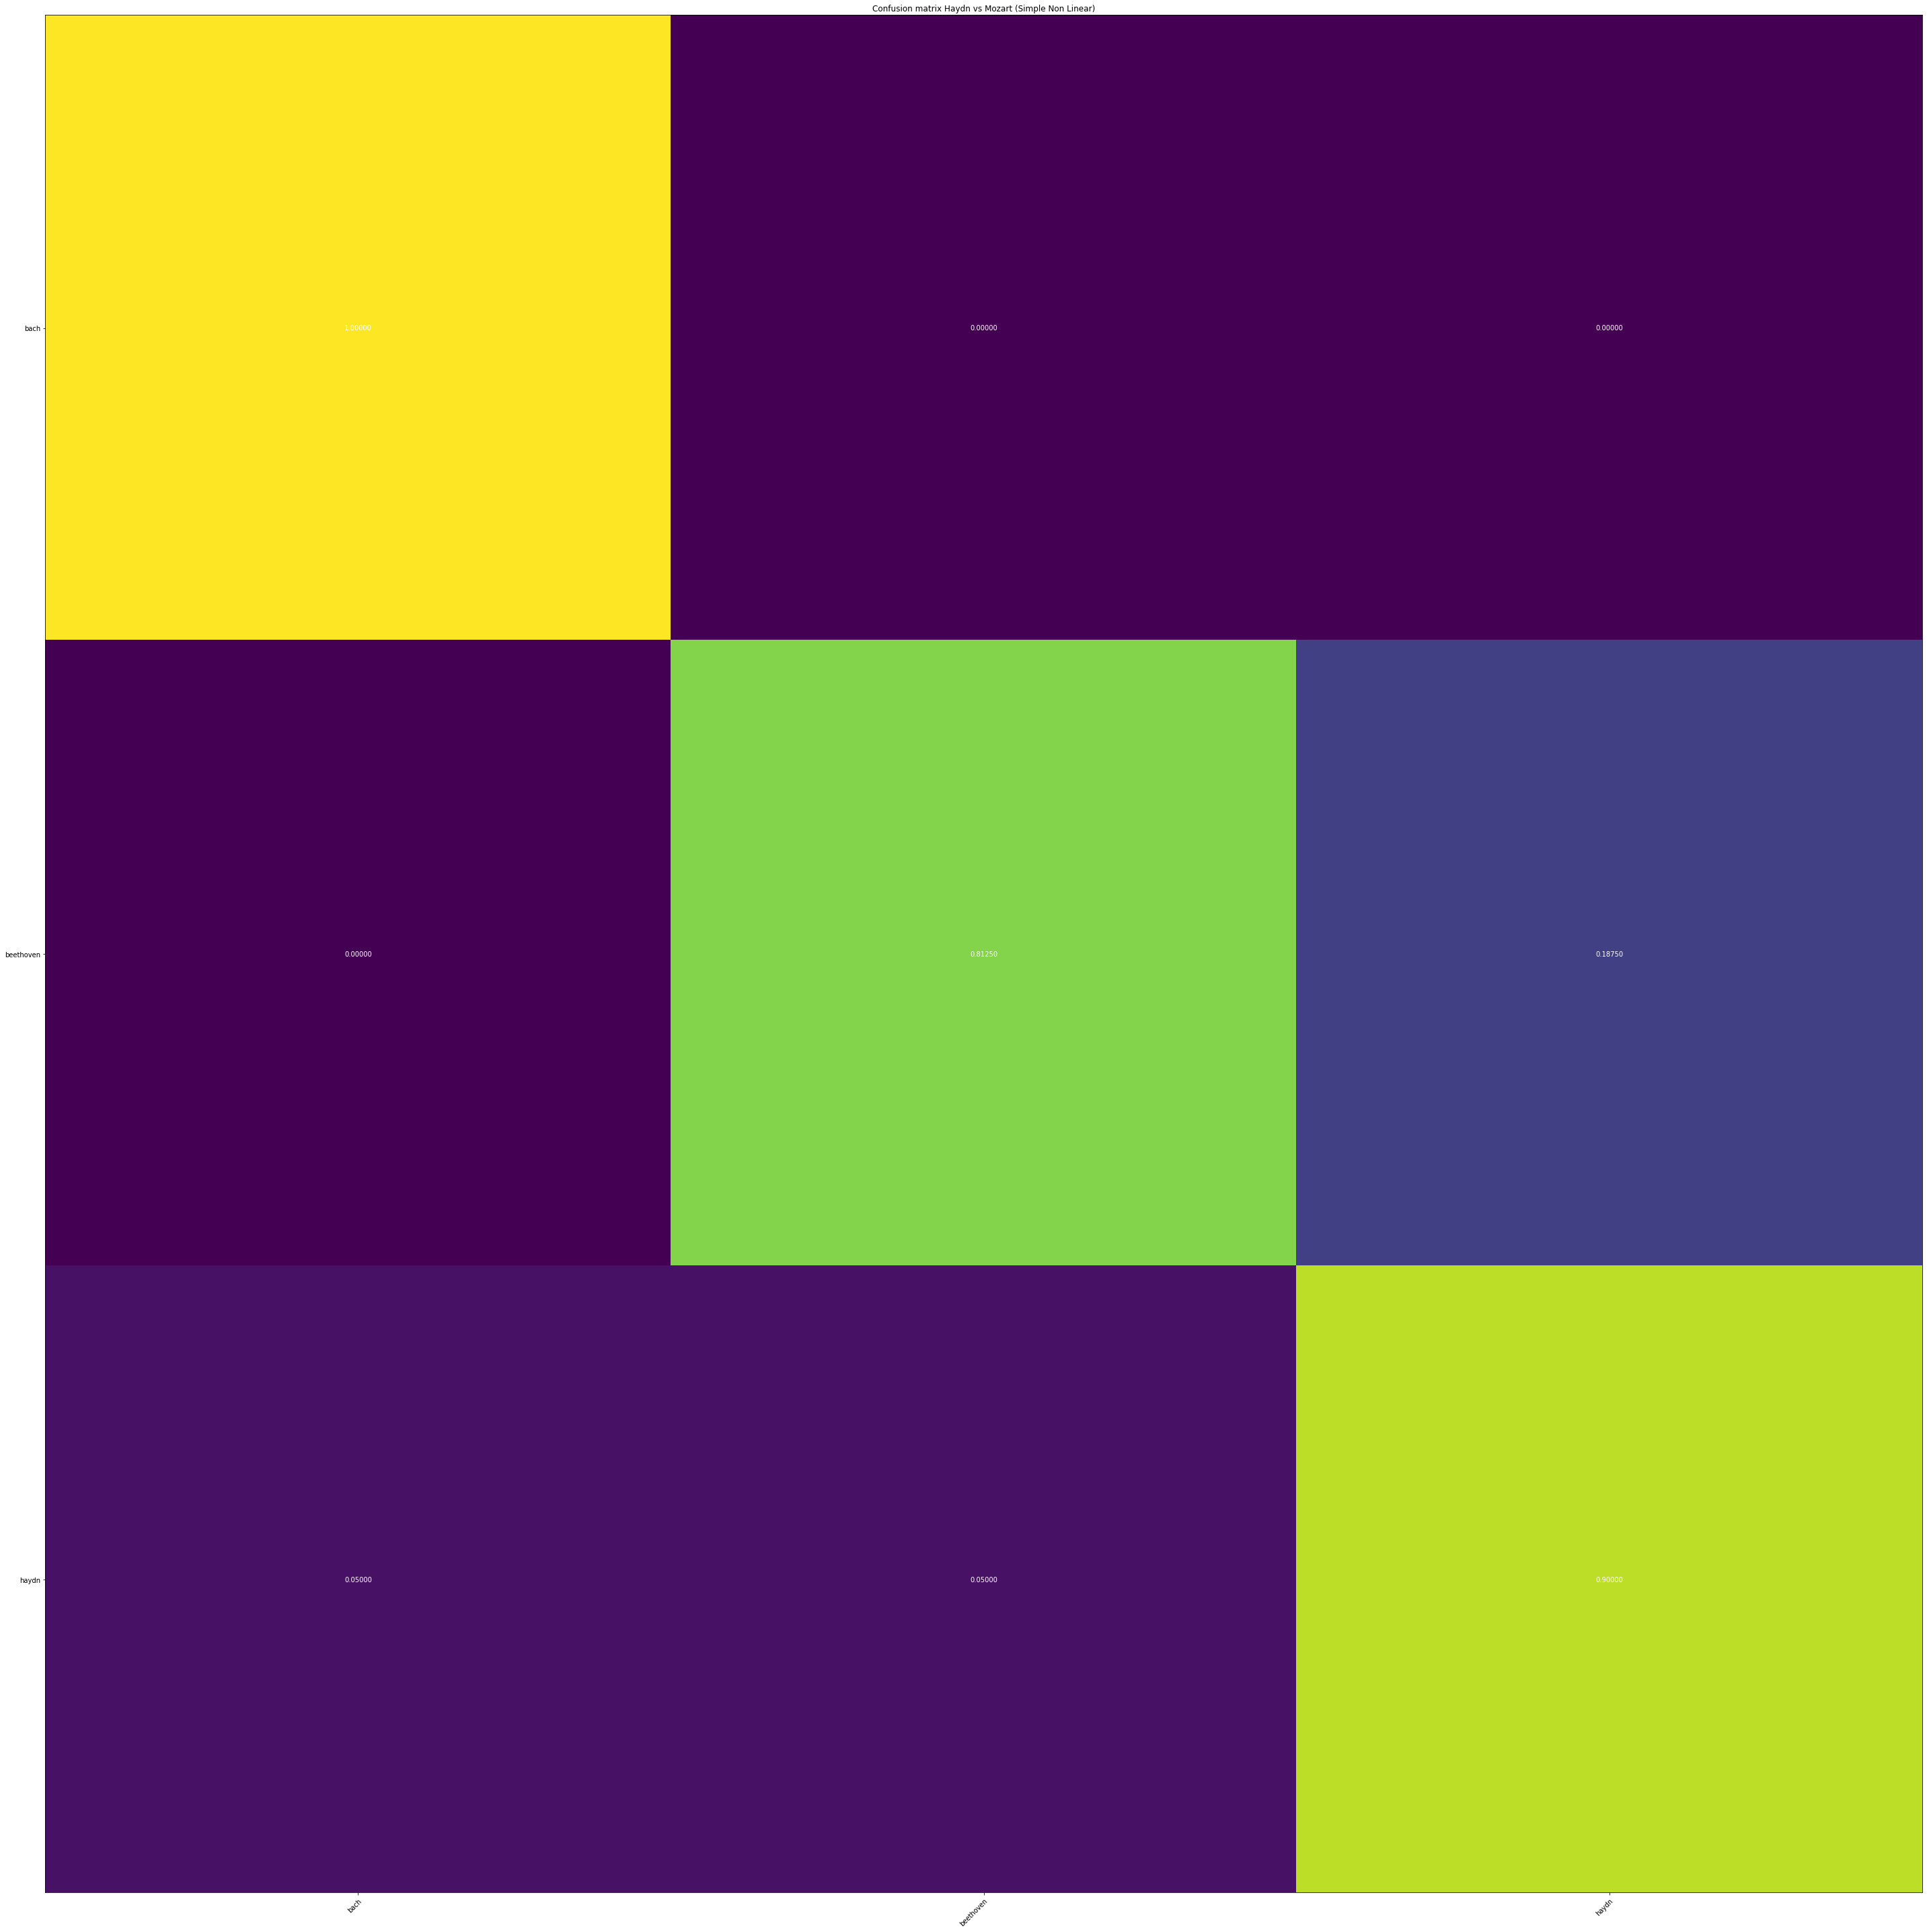

bach 46 / 46 = 1.0
beethoven 13 / 16 = 0.8125
haydn 18 / 20 = 0.9
77 82 0.9390243902439024
---------------------------------------------
---------------------------------------------
Fold 1
len validation_ids 246
len test_ids 246
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
wnotes torch.Size([64, 1, 1, 6, 39]) (14976)
wnotes2 torch.Size([512, 64, 1]) (32768)
wdur torch.Size([512, 330, 1]) (168960)
wtop torch.Size([512, 3]) (1536)
wnotesm torch.Size([256, 78, 1, 3]) (59904)
wdurationm torch.Size([256, 55, 1, 3]) (42240)
w2m torch.Size([256, 256, 1, 3]) (196608)
wtopm torch.Size([256, 3]) (768)
bias torch.Size([3]) (3)
Initialized graph with 517763 parameters
Initiating optimizer, 22 iterations/epoch.
acc_tr	acc_ts	iter	loss_tr	loss_ts	time	utime
25.00   24.39   0       4.17    3.27    4.31    3.22    
75.50   67.07   22      0.95    1.14    7.91    2.96    
67.50   62.20   4

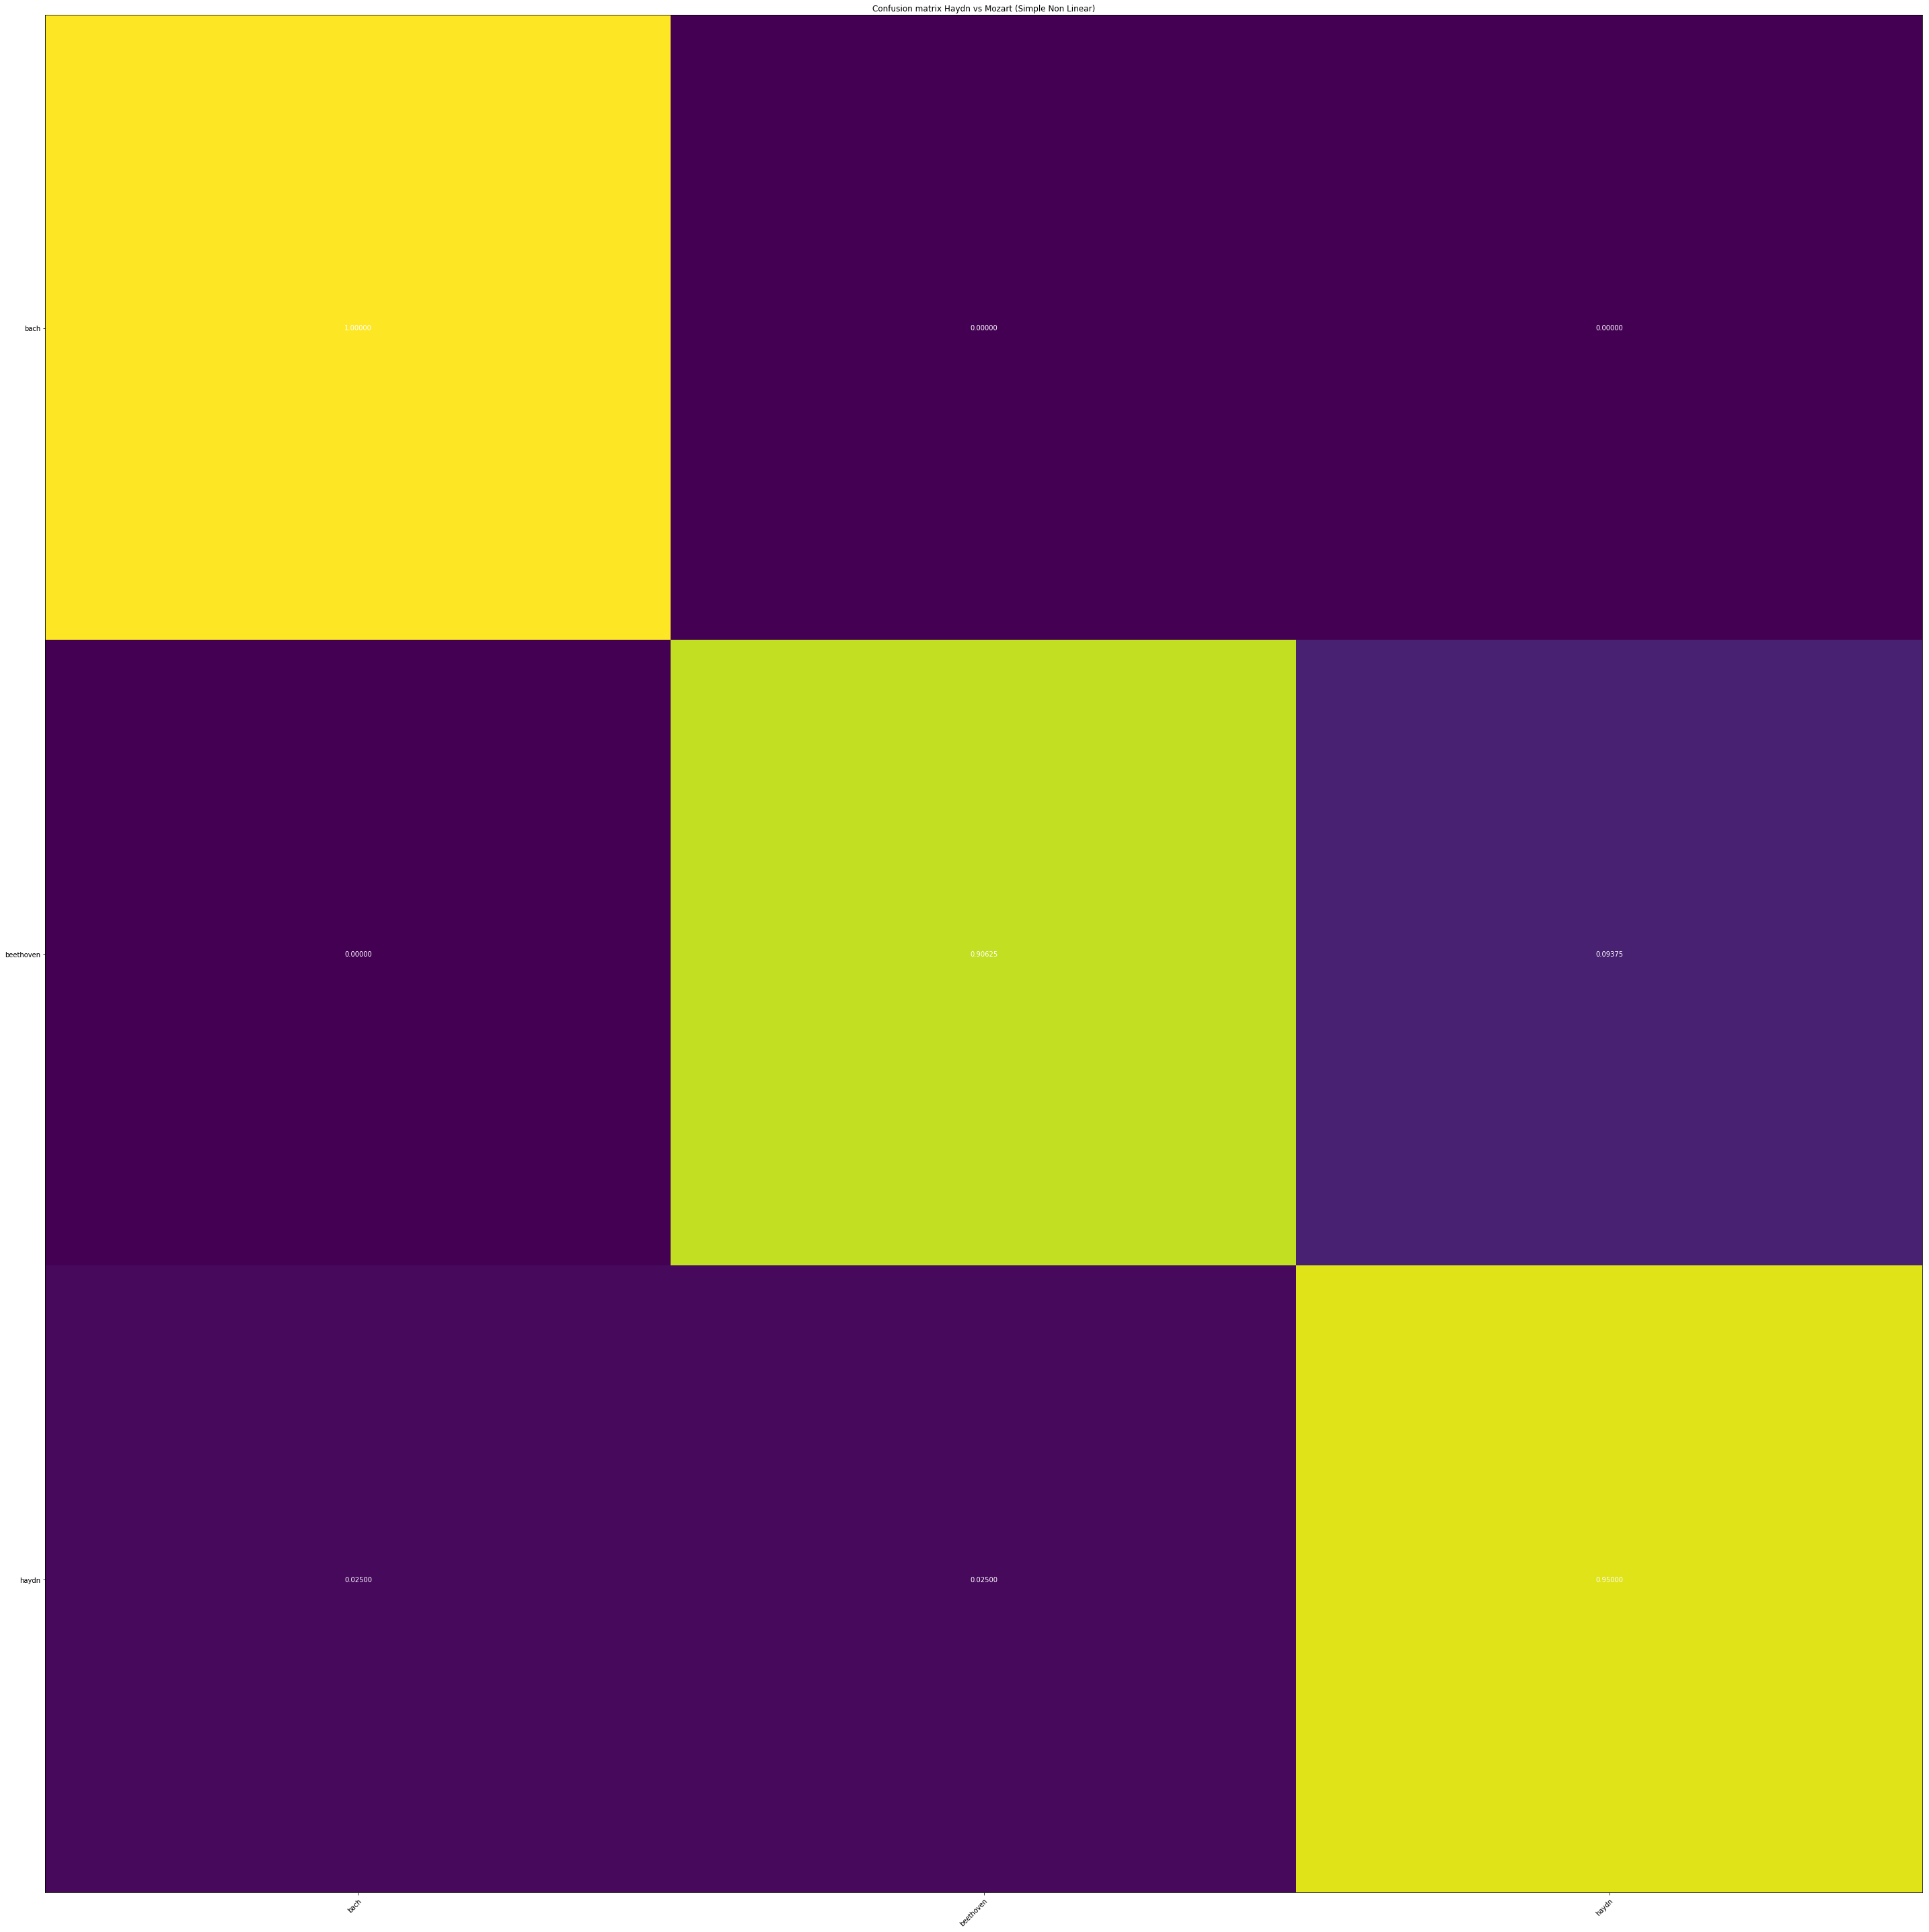

bach 46 / 46 = 1.0
beethoven 16 / 16 = 1.0
haydn 20 / 20 = 1.0
82 82 1.0
---------------------------------------------
---------------------------------------------
Fold 2
len validation_ids 246
len test_ids 246
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
wnotes torch.Size([64, 1, 1, 6, 39]) (14976)
wnotes2 torch.Size([512, 64, 1]) (32768)
wdur torch.Size([512, 330, 1]) (168960)
wtop torch.Size([512, 3]) (1536)
wnotesm torch.Size([256, 78, 1, 3]) (59904)
wdurationm torch.Size([256, 55, 1, 3]) (42240)
w2m torch.Size([256, 256, 1, 3]) (196608)
wtopm torch.Size([256, 3]) (768)
bias torch.Size([3]) (3)
Initialized graph with 517763 parameters
Initiating optimizer, 22 iterations/epoch.
acc_tr	acc_ts	iter	loss_tr	loss_ts	time	utime
55.00   56.10   0       3.61    4.52    4.20    3.22    
74.00   76.83   22      0.86    0.91    7.83    3.16    
75.00   80.49   44      0.79    0.8

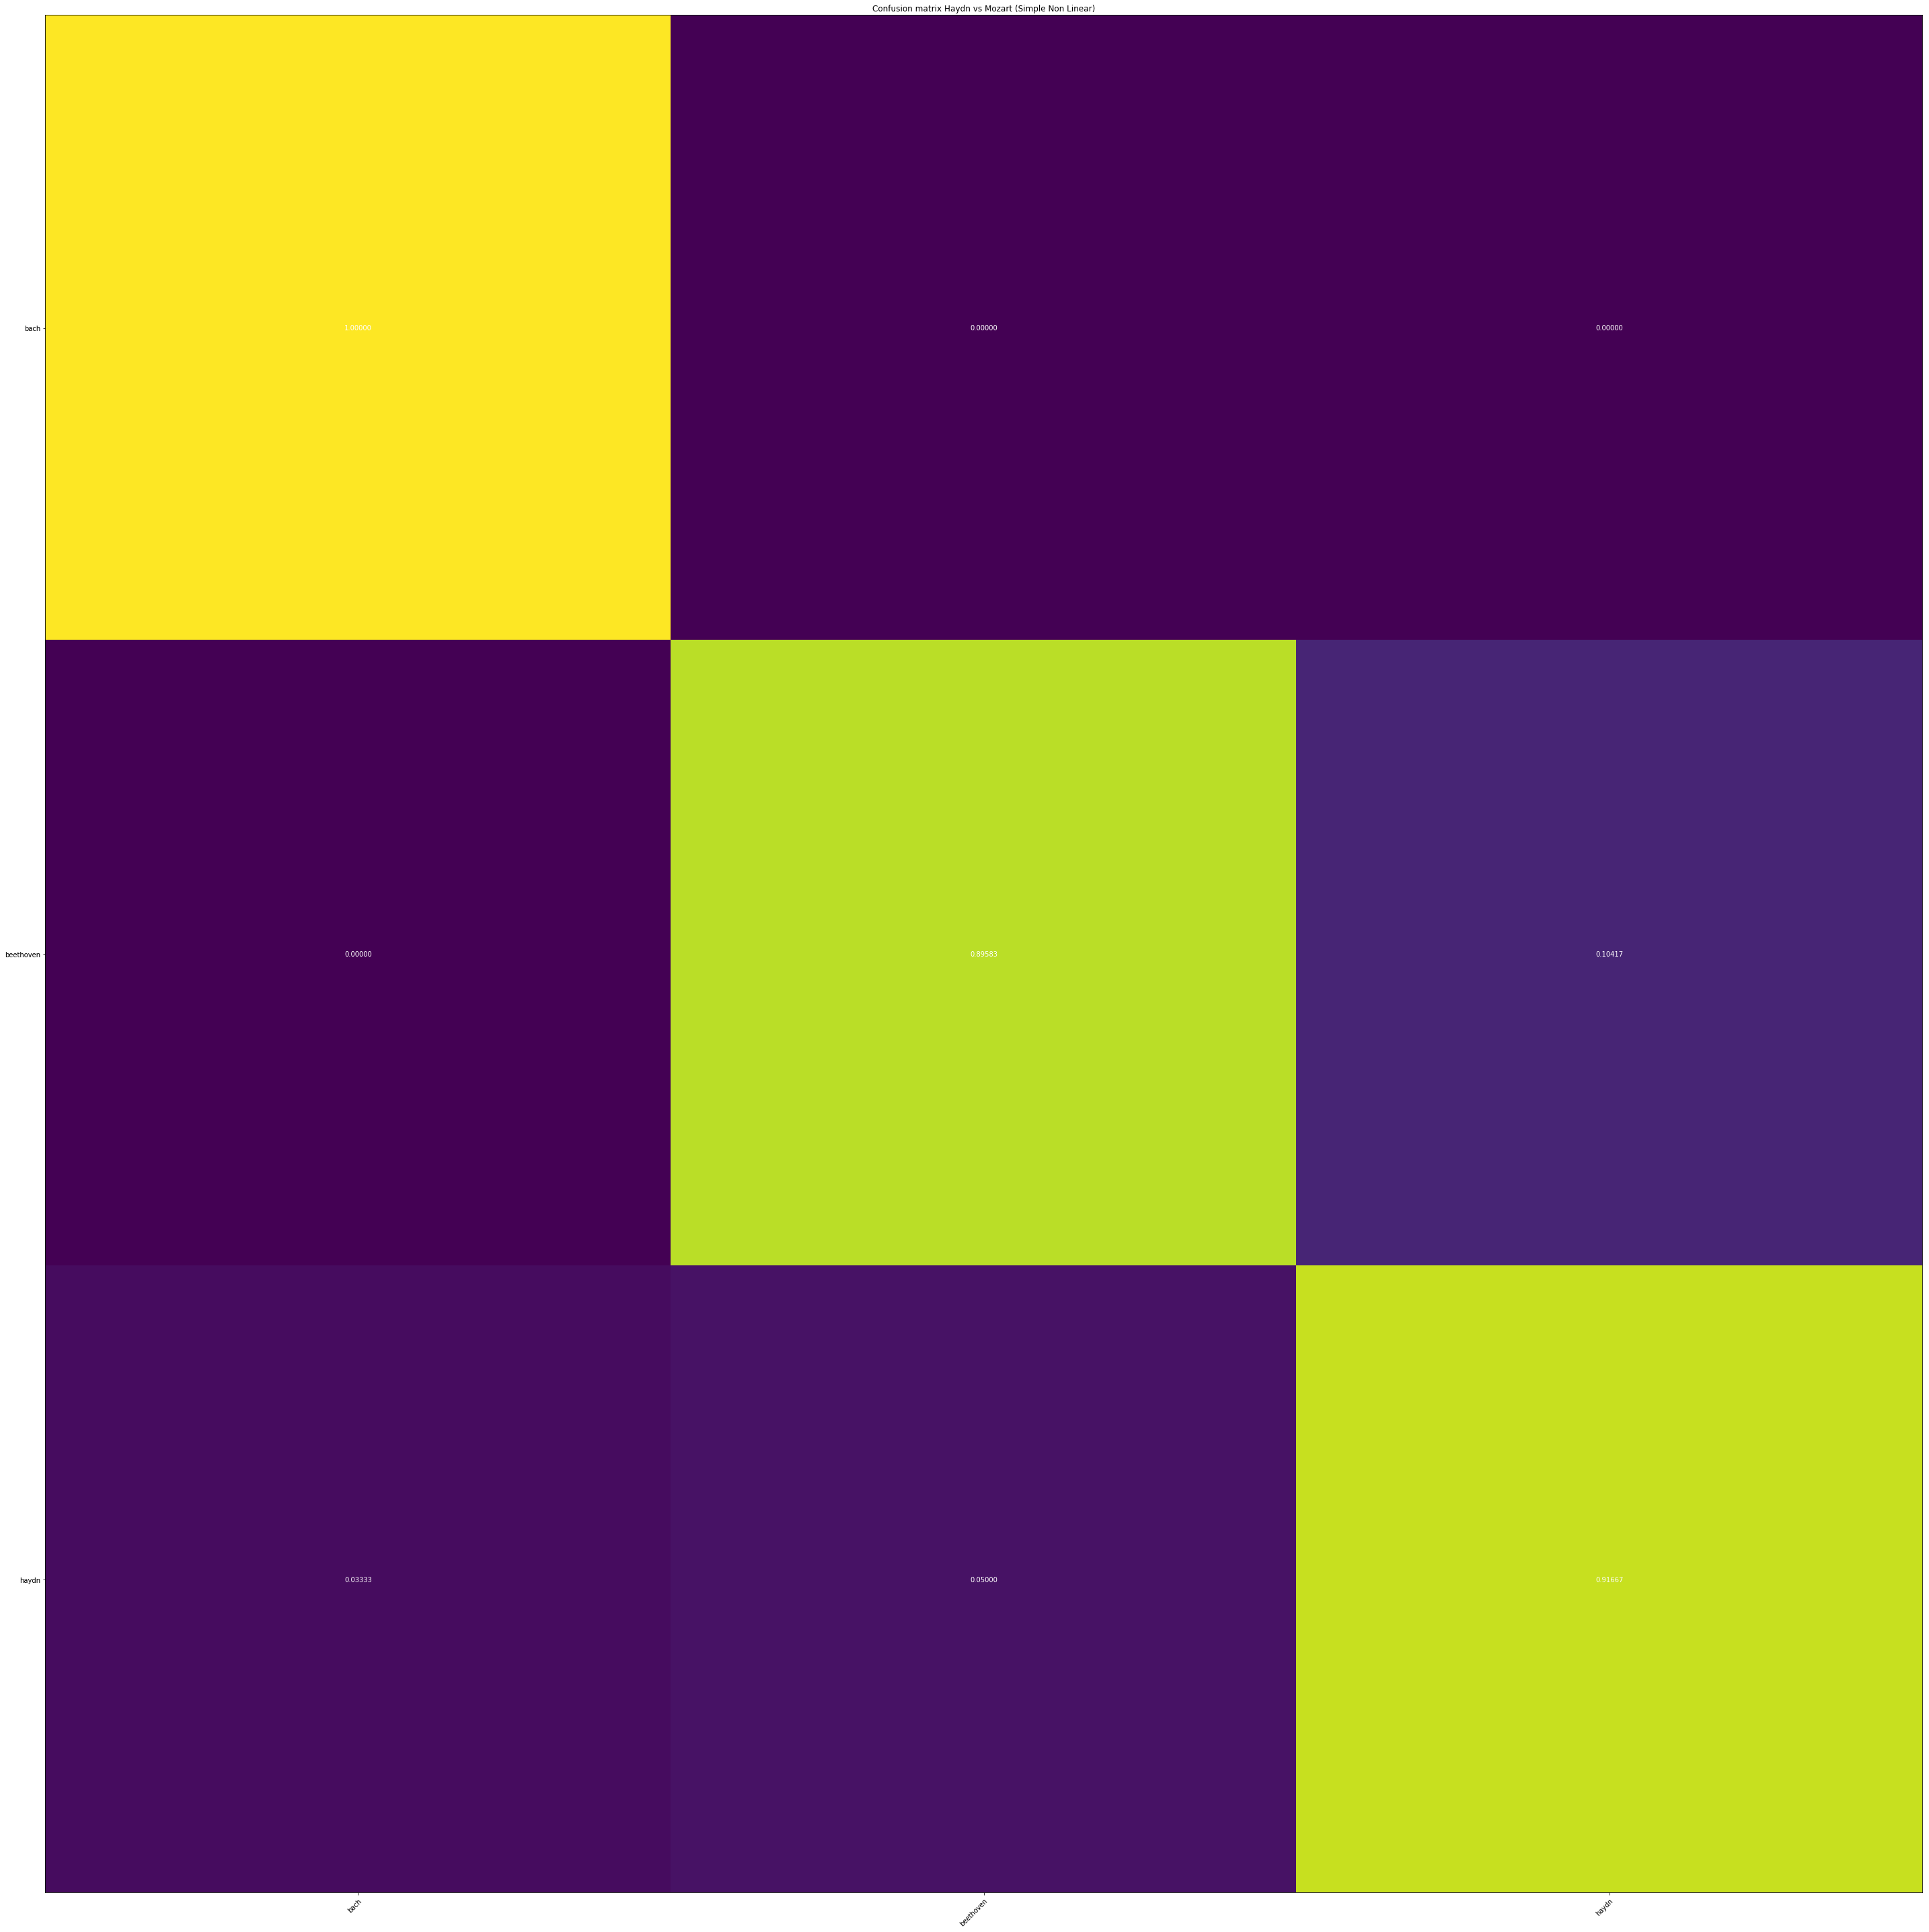

bach 46 / 46 = 1.0
beethoven 14 / 16 = 0.875
haydn 17 / 20 = 0.85
77 82 0.9390243902439024
---------------------------------------------
---------------------------------------------
Fold 3
len validation_ids 246
len test_ids 246
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
wnotes torch.Size([64, 1, 1, 6, 39]) (14976)
wnotes2 torch.Size([512, 64, 1]) (32768)
wdur torch.Size([512, 330, 1]) (168960)
wtop torch.Size([512, 3]) (1536)
wnotesm torch.Size([256, 78, 1, 3]) (59904)
wdurationm torch.Size([256, 55, 1, 3]) (42240)
w2m torch.Size([256, 256, 1, 3]) (196608)
wtopm torch.Size([256, 3]) (768)
bias torch.Size([3]) (3)
Initialized graph with 517763 parameters
Initiating optimizer, 22 iterations/epoch.
acc_tr	acc_ts	iter	loss_tr	loss_ts	time	utime
39.00   40.24   0       1.79    1.76    4.20    3.28    
76.50   79.27   22      0.86    0.82    7.90    3.07    
75.50   76.83   4

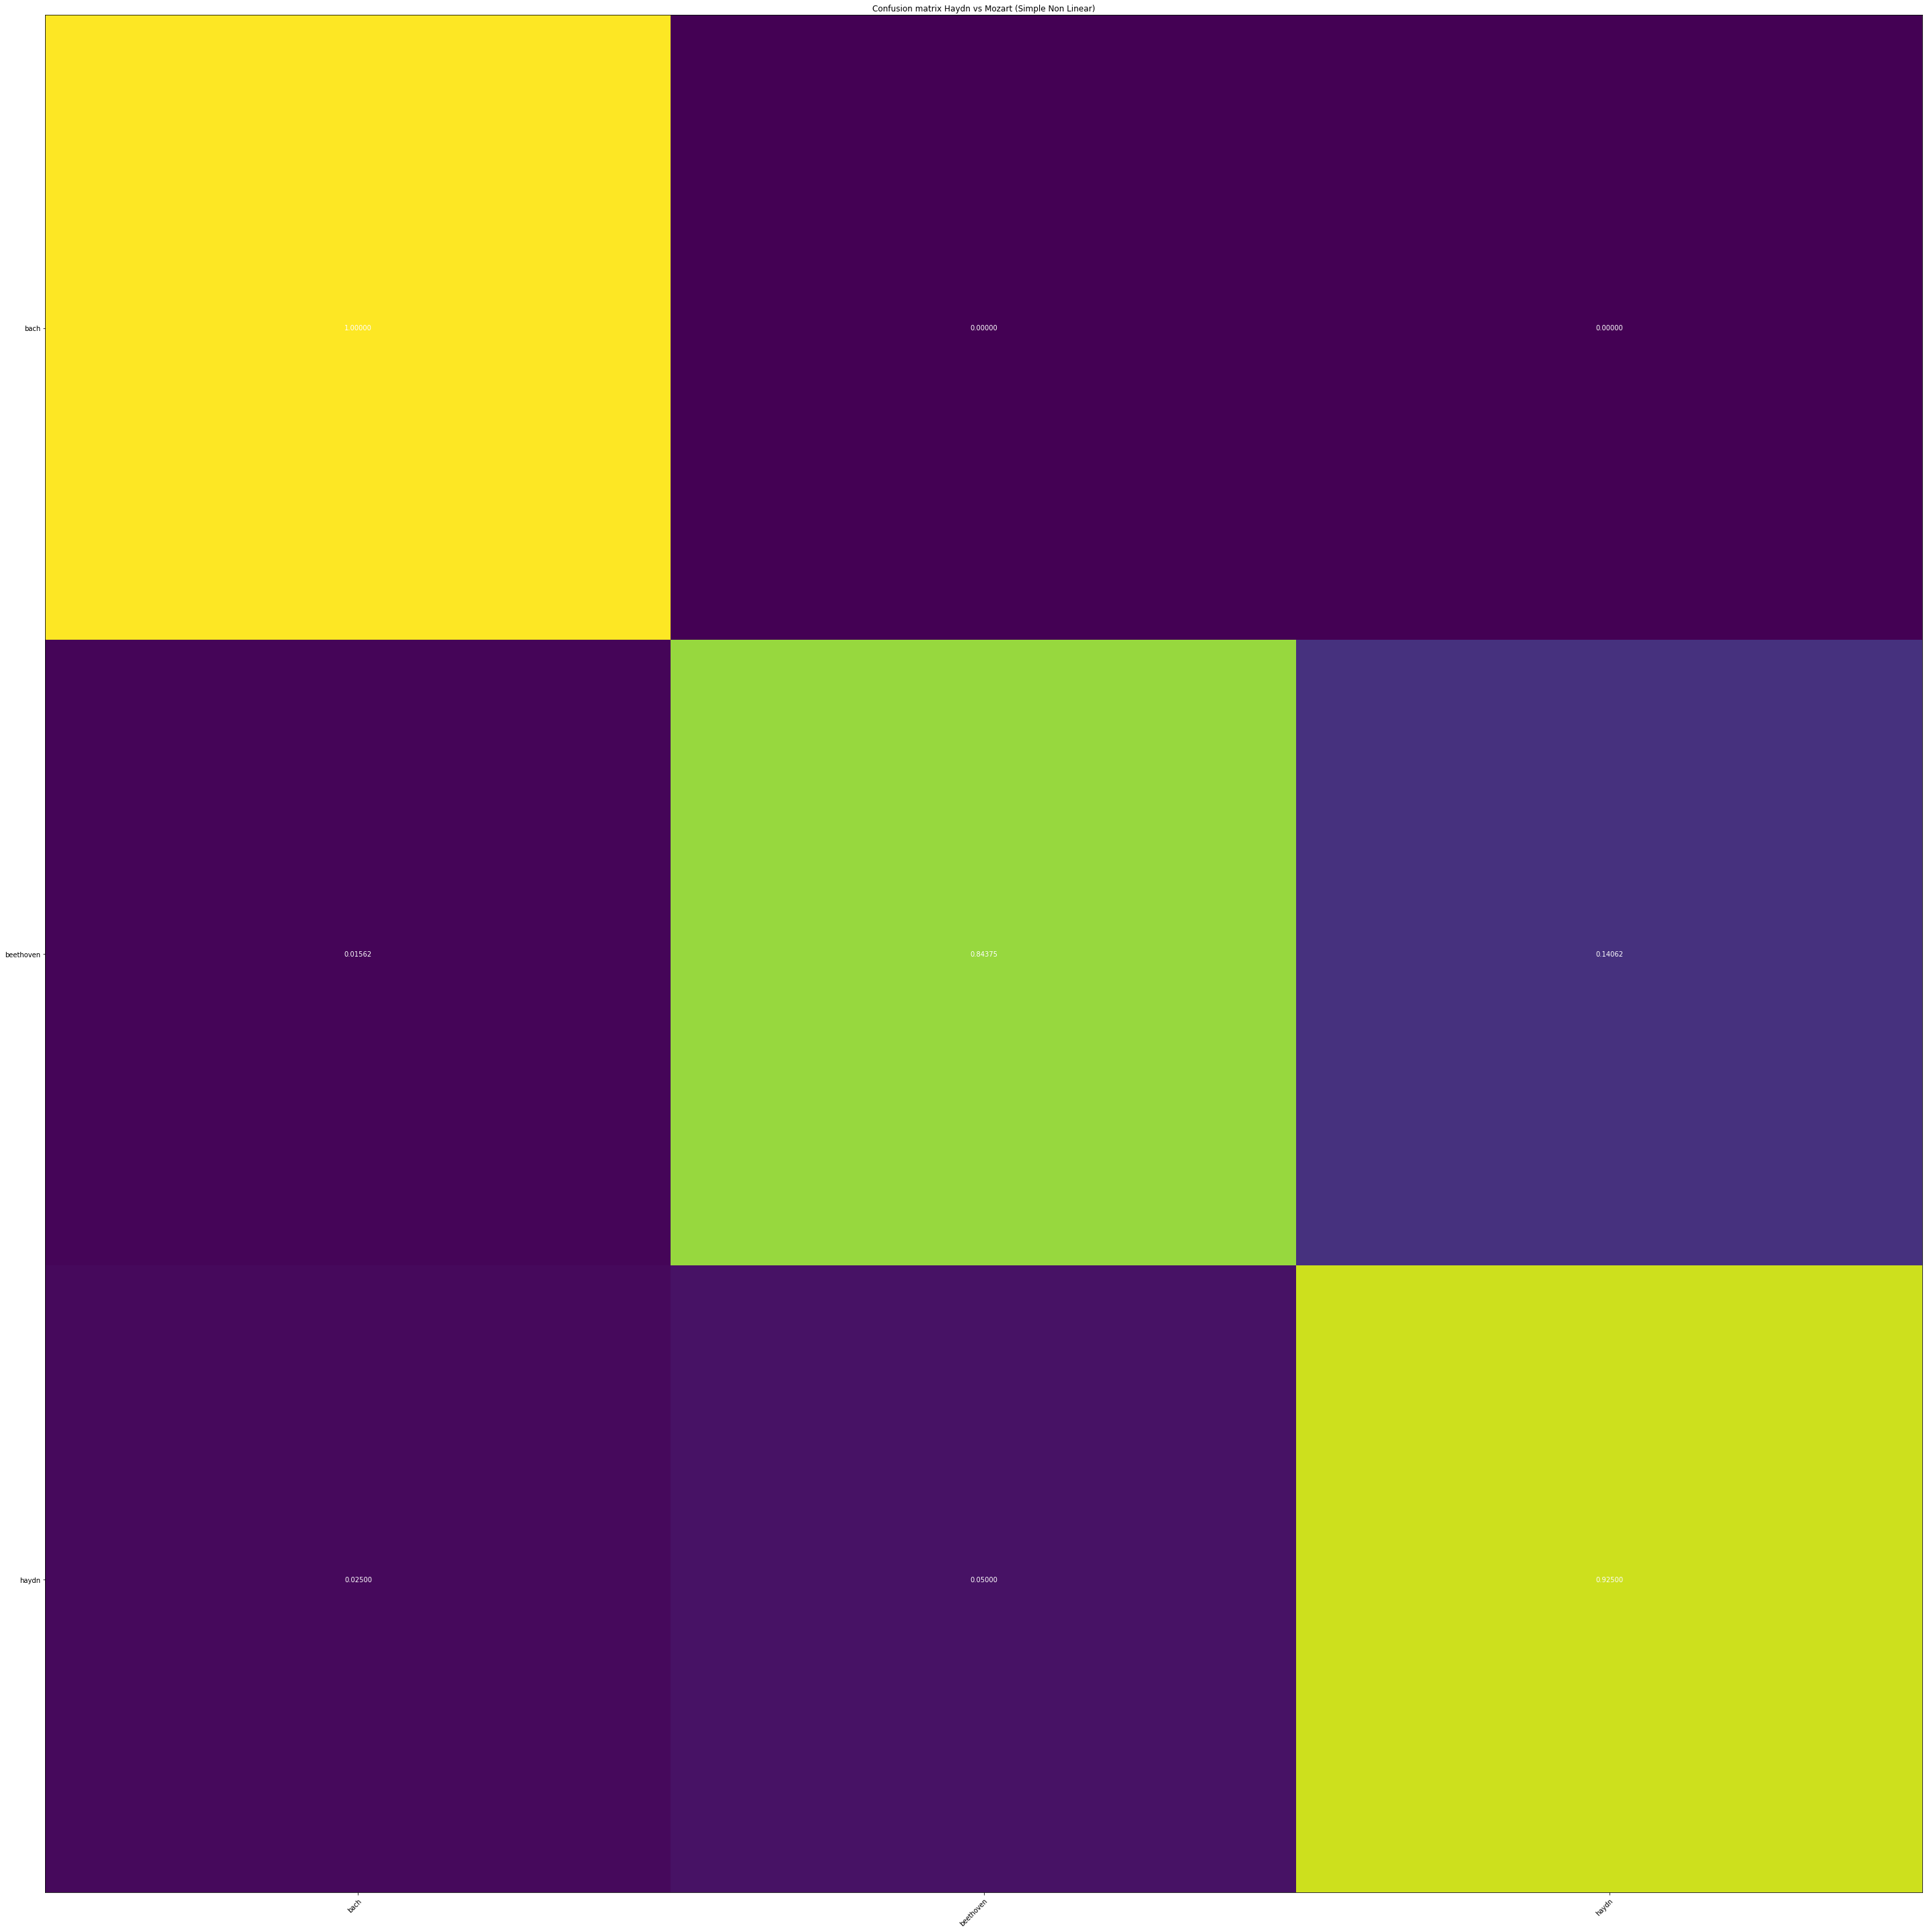

bach 46 / 46 = 1.0
beethoven 11 / 16 = 0.6875
haydn 19 / 20 = 0.95
76 82 0.926829268292683
---------------------------------------------
---------------------------------------------
Fold 4
len validation_ids 246
len test_ids 246
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
wnotes torch.Size([64, 1, 1, 6, 39]) (14976)
wnotes2 torch.Size([512, 64, 1]) (32768)
wdur torch.Size([512, 330, 1]) (168960)
wtop torch.Size([512, 3]) (1536)
wnotesm torch.Size([256, 78, 1, 3]) (59904)
wdurationm torch.Size([256, 55, 1, 3]) (42240)
w2m torch.Size([256, 256, 1, 3]) (196608)
wtopm torch.Size([256, 3]) (768)
bias torch.Size([3]) (3)
Initialized graph with 517763 parameters
Initiating optimizer, 22 iterations/epoch.
acc_tr	acc_ts	iter	loss_tr	loss_ts	time	utime
25.00   24.39   0       1.86    1.67    3.06    2.40    
60.50   63.41   22      1.02    1.05    6.81    2.18    
74.50   74.39   4

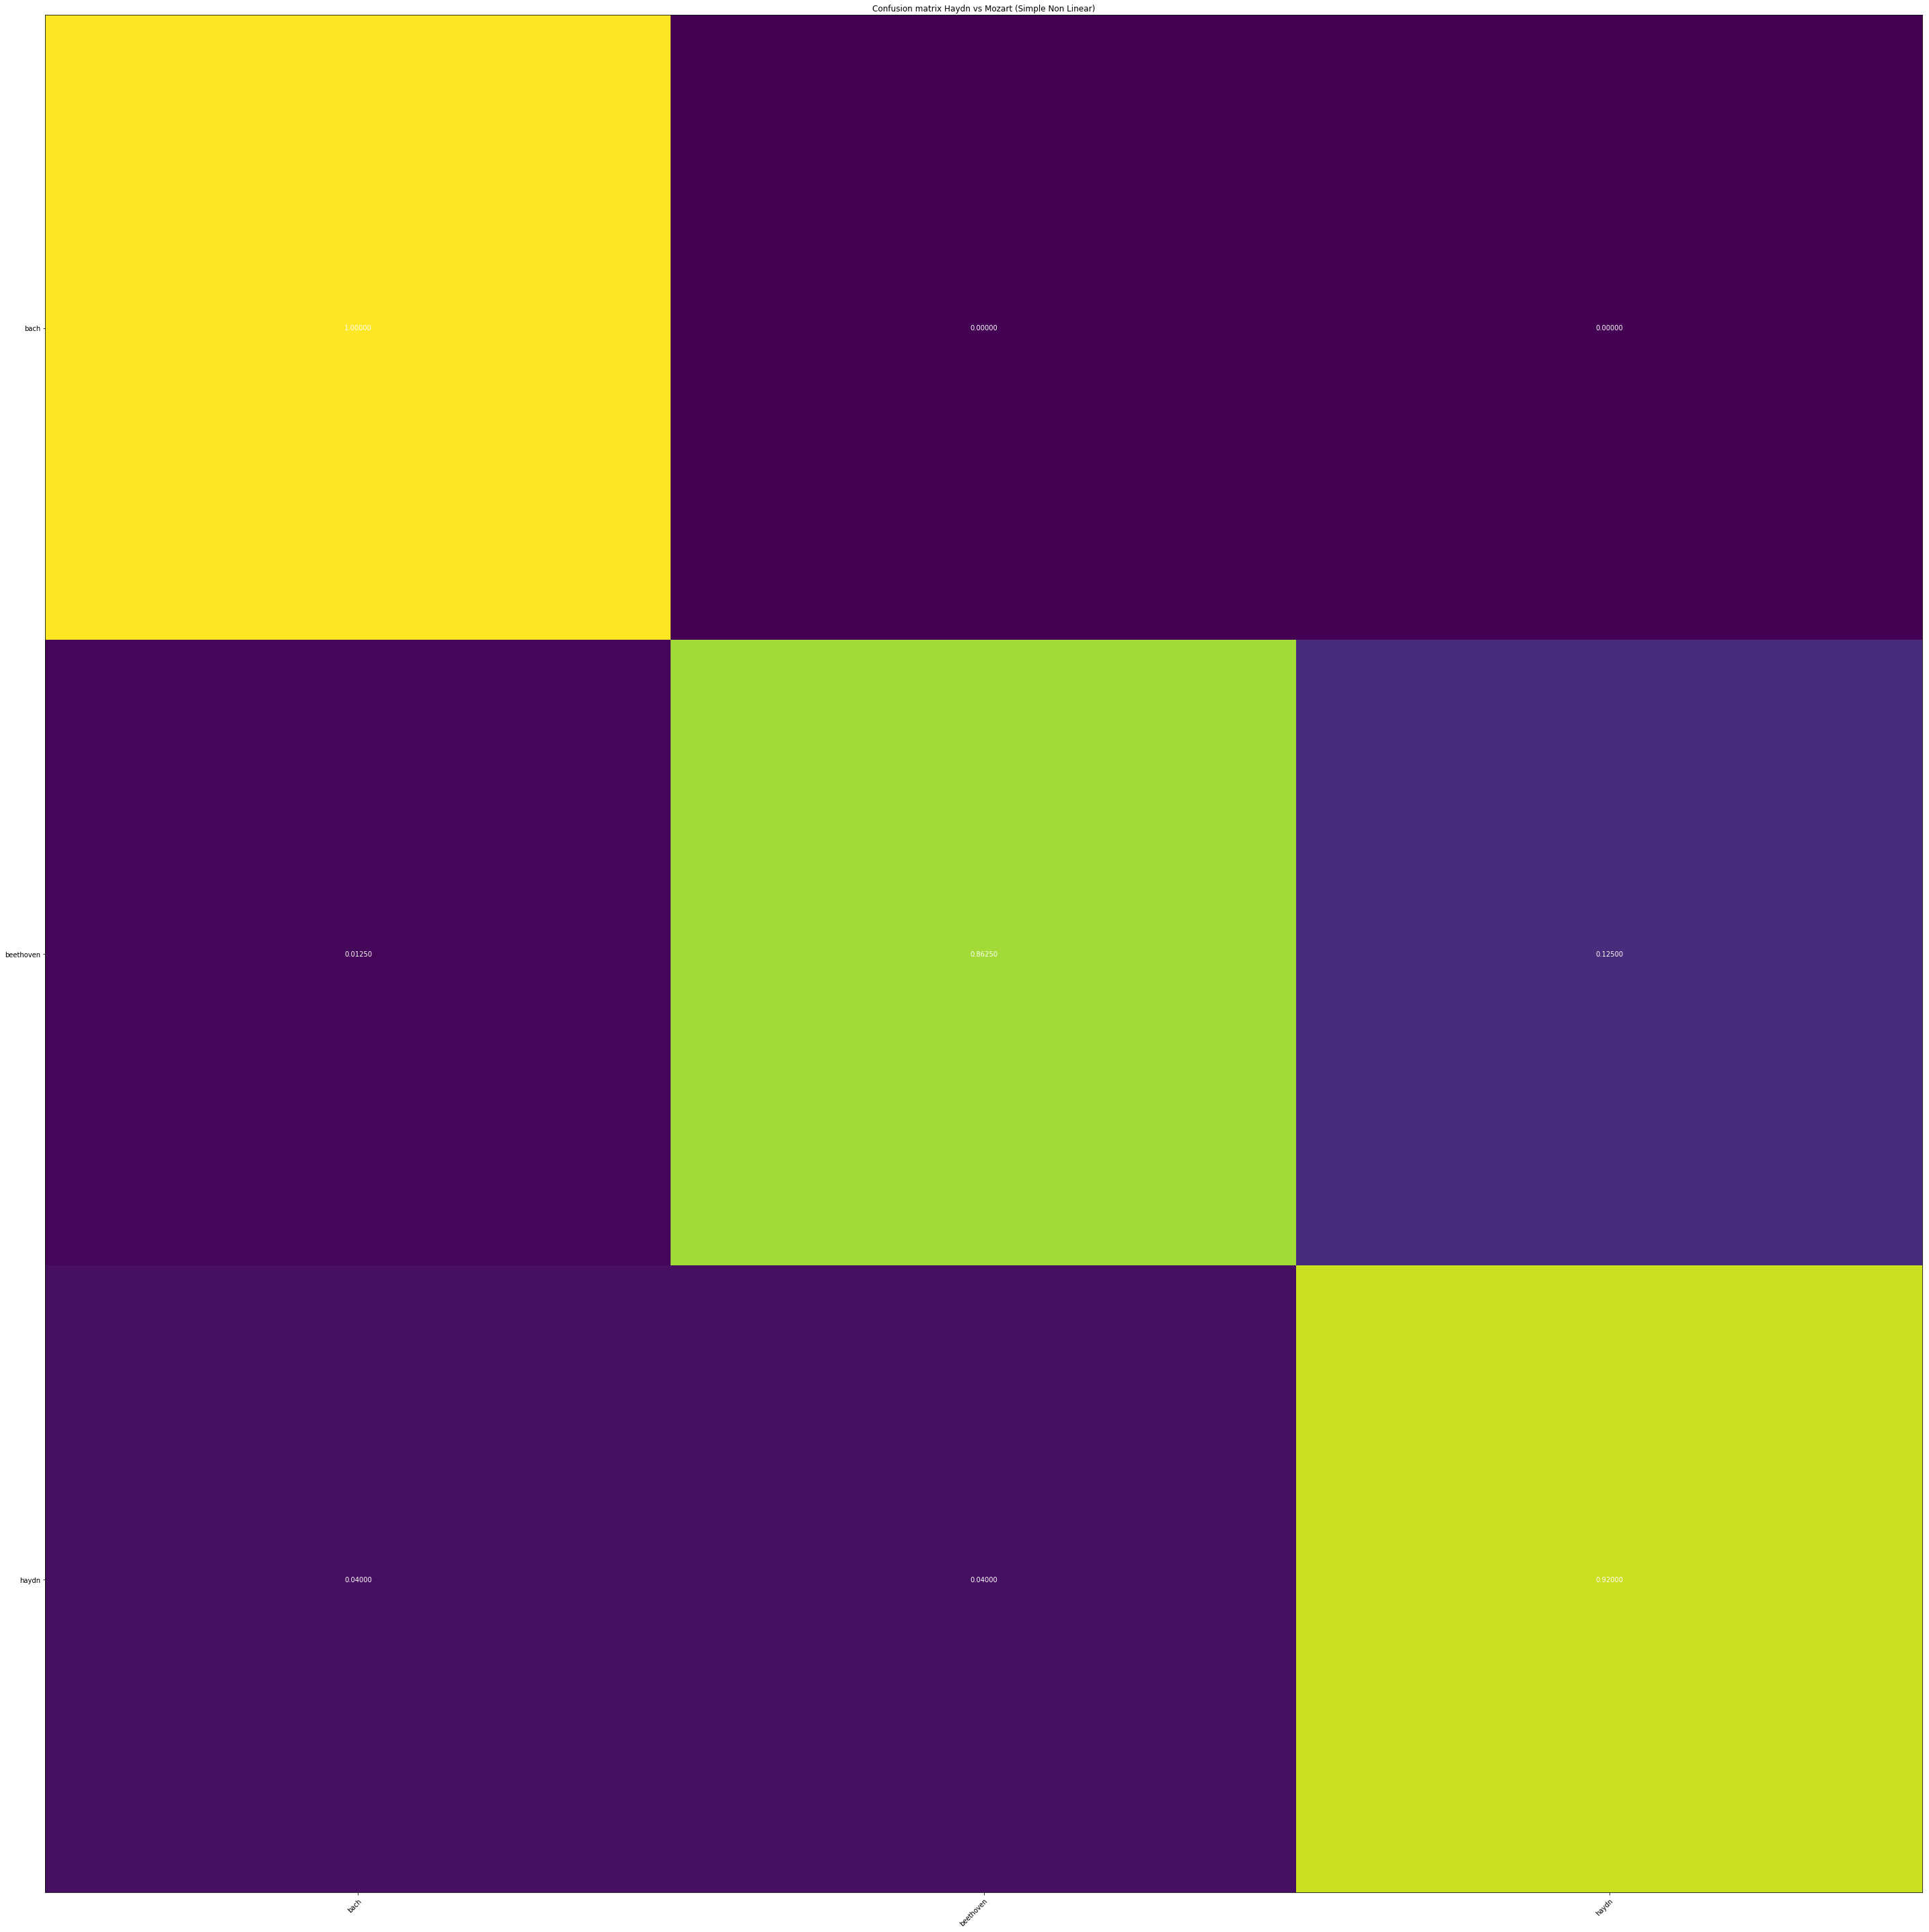

bach 46 / 46 = 1.0
beethoven 15 / 16 = 0.9375
haydn 18 / 20 = 0.9
79 82 0.9634146341463414
---------------------------------------------
---------------------------------------------
Fold 5
len validation_ids 246
len test_ids 246
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
wnotes torch.Size([64, 1, 1, 6, 39]) (14976)
wnotes2 torch.Size([512, 64, 1]) (32768)
wdur torch.Size([512, 330, 1]) (168960)
wtop torch.Size([512, 3]) (1536)
wnotesm torch.Size([256, 78, 1, 3]) (59904)
wdurationm torch.Size([256, 55, 1, 3]) (42240)
w2m torch.Size([256, 256, 1, 3]) (196608)
wtopm torch.Size([256, 3]) (768)
bias torch.Size([3]) (3)
Initialized graph with 517763 parameters
Initiating optimizer, 22 iterations/epoch.
acc_tr	acc_ts	iter	loss_tr	loss_ts	time	utime
25.00   25.61   0       3.35    2.93    2.96    2.23    
62.50   67.07   22      1.02    1.17    6.83    2.33    
73.50   74.39   4

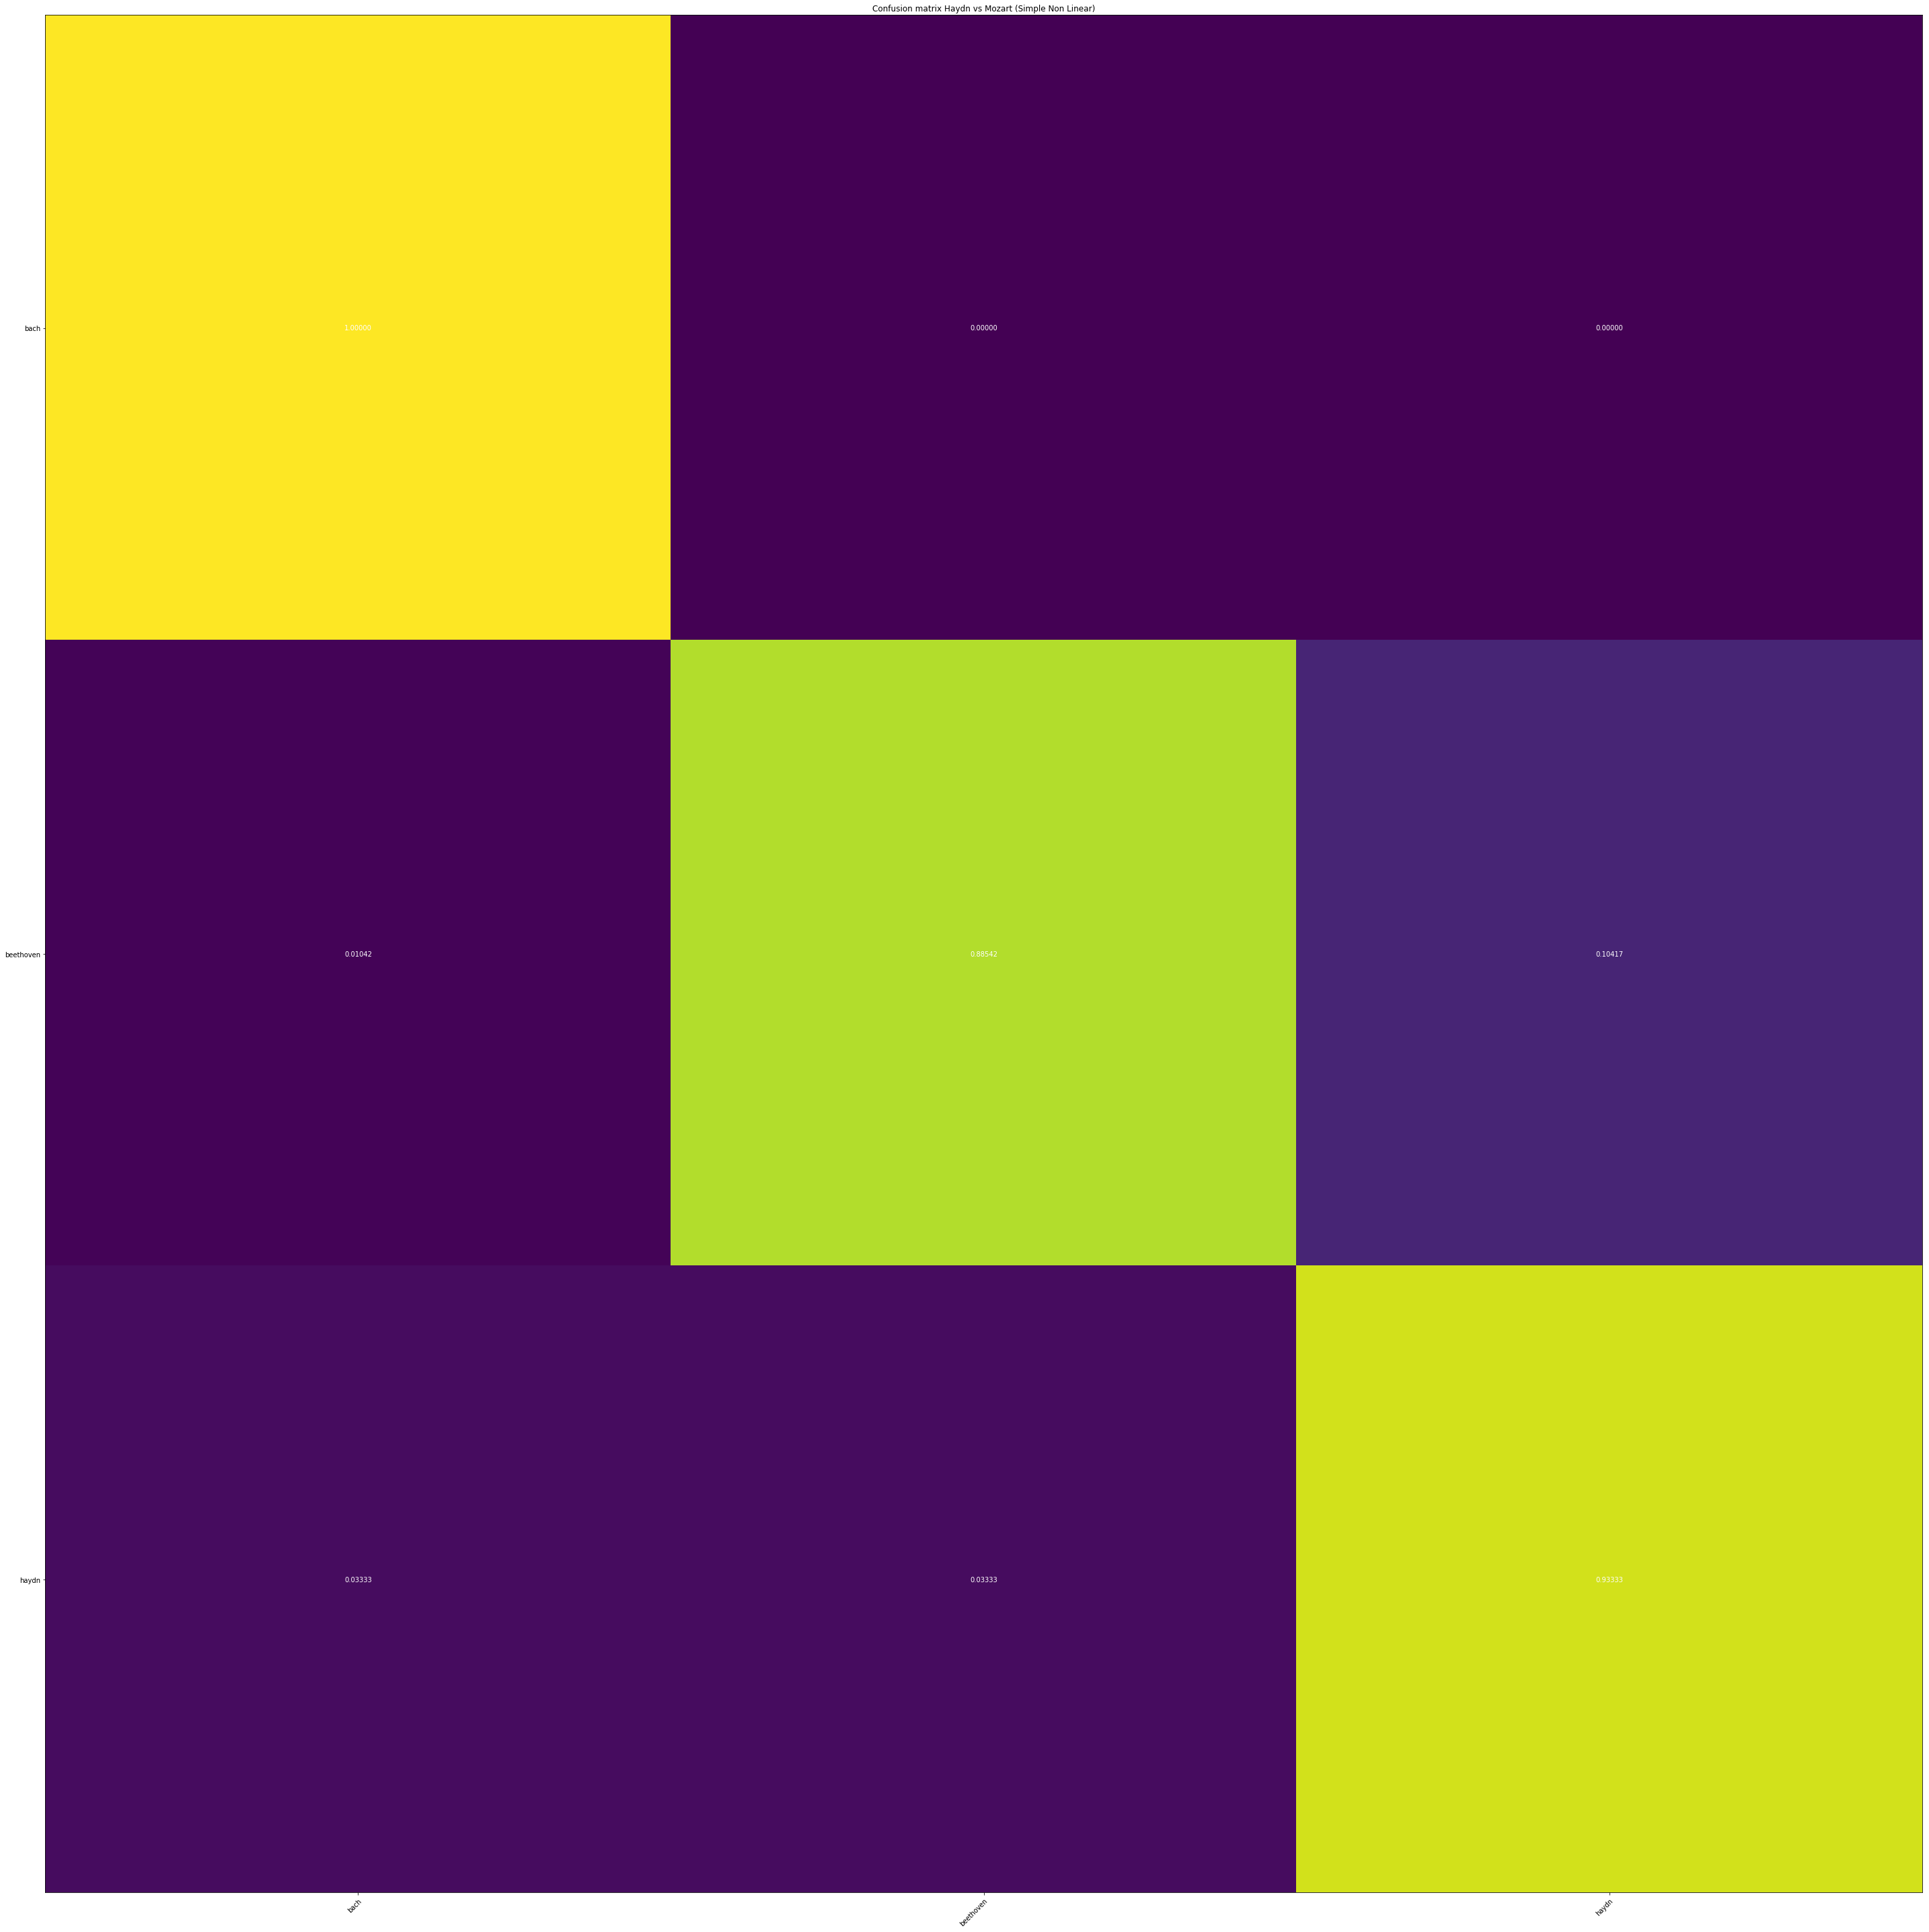

bach 46 / 46 = 1.0
beethoven 16 / 16 = 1.0
haydn 20 / 20 = 1.0
82 82 1.0
---------------------------------------------
---------------------------------------------
Fold 6
len validation_ids 246
len test_ids 246
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
wnotes torch.Size([64, 1, 1, 6, 39]) (14976)
wnotes2 torch.Size([512, 64, 1]) (32768)
wdur torch.Size([512, 330, 1]) (168960)
wtop torch.Size([512, 3]) (1536)
wnotesm torch.Size([256, 78, 1, 3]) (59904)
wdurationm torch.Size([256, 55, 1, 3]) (42240)
w2m torch.Size([256, 256, 1, 3]) (196608)
wtopm torch.Size([256, 3]) (768)
bias torch.Size([3]) (3)
Initialized graph with 517763 parameters
Initiating optimizer, 22 iterations/epoch.
acc_tr	acc_ts	iter	loss_tr	loss_ts	time	utime
25.00   24.39   0       4.52    3.95    2.89    2.28    
63.50   63.41   22      1.26    1.51    6.80    2.31    
74.00   75.61   44      0.88    0.9

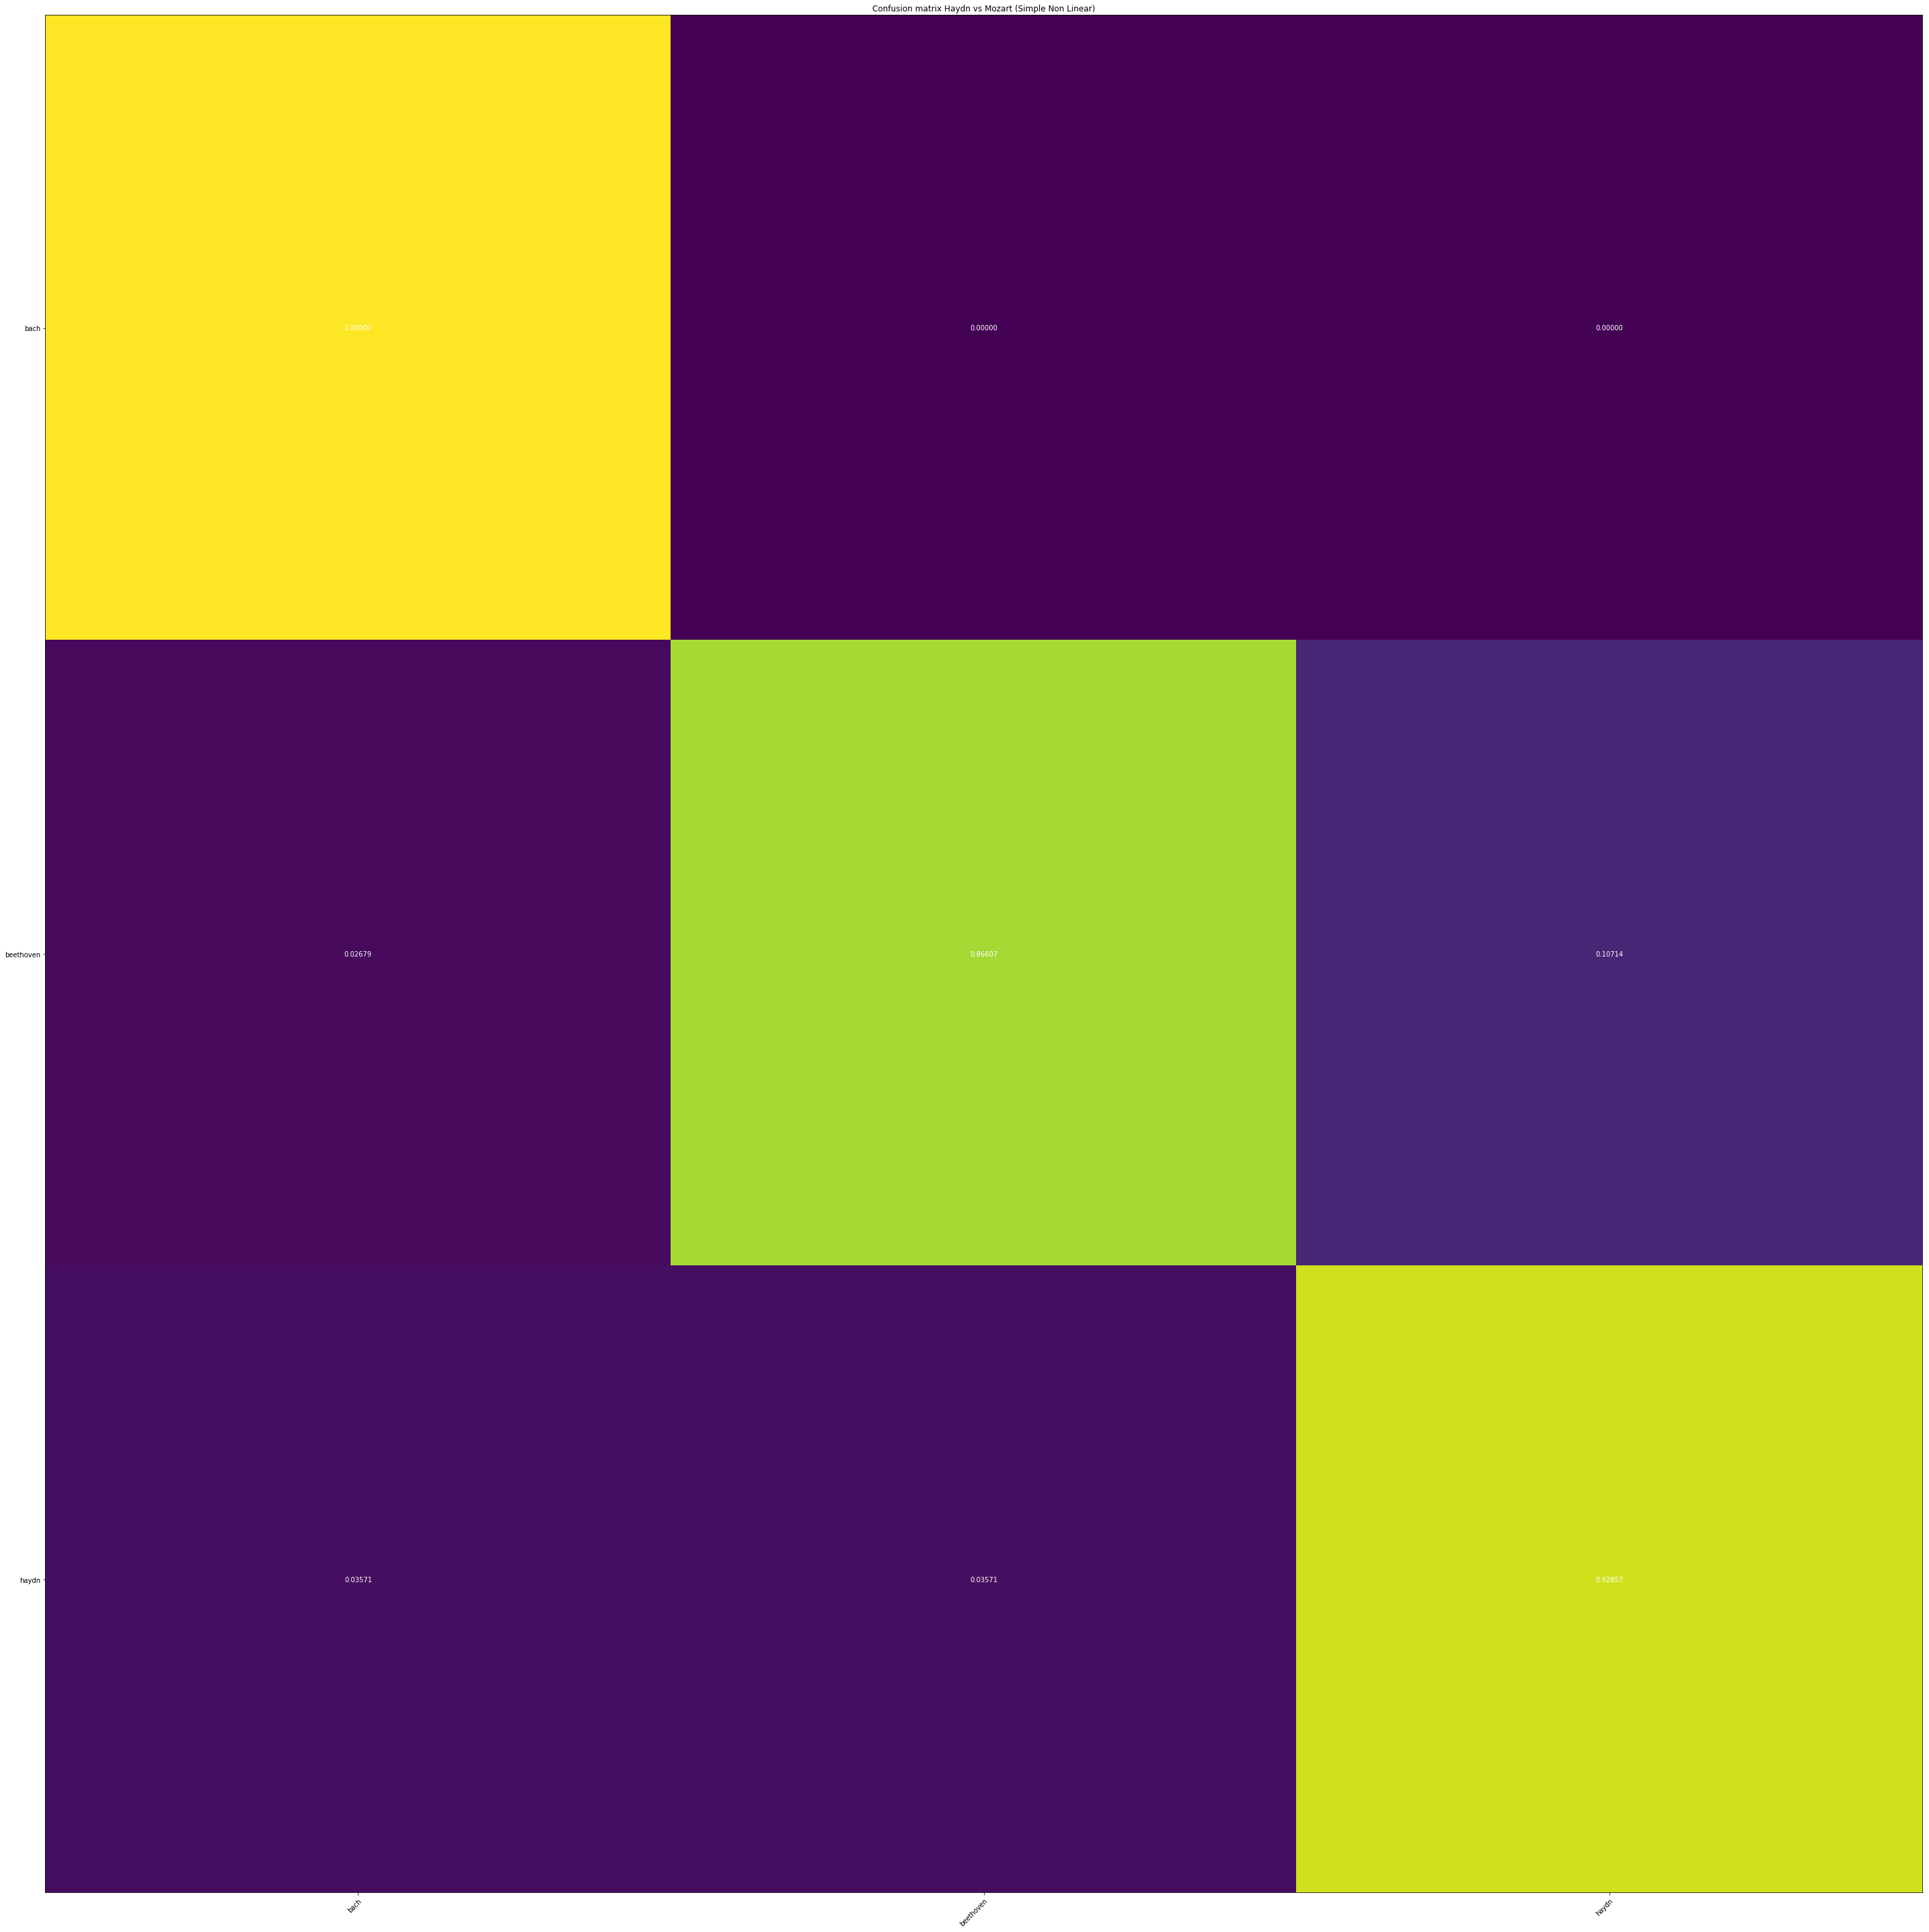

bach 46 / 46 = 1.0
beethoven 12 / 16 = 0.75
haydn 18 / 20 = 0.9
76 82 0.926829268292683
---------------------------------------------
---------------------------------------------
Fold 7
len validation_ids 246
len test_ids 246
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
wnotes torch.Size([64, 1, 1, 6, 39]) (14976)
wnotes2 torch.Size([512, 64, 1]) (32768)
wdur torch.Size([512, 330, 1]) (168960)
wtop torch.Size([512, 3]) (1536)
wnotesm torch.Size([256, 78, 1, 3]) (59904)
wdurationm torch.Size([256, 55, 1, 3]) (42240)
w2m torch.Size([256, 256, 1, 3]) (196608)
wtopm torch.Size([256, 3]) (768)
bias torch.Size([3]) (3)
Initialized graph with 517763 parameters
Initiating optimizer, 22 iterations/epoch.
acc_tr	acc_ts	iter	loss_tr	loss_ts	time	utime
20.00   19.51   0       4.29    5.11    3.15    2.38    
66.00   69.51   22      1.39    1.18    6.95    2.28    
76.00   79.27   44  

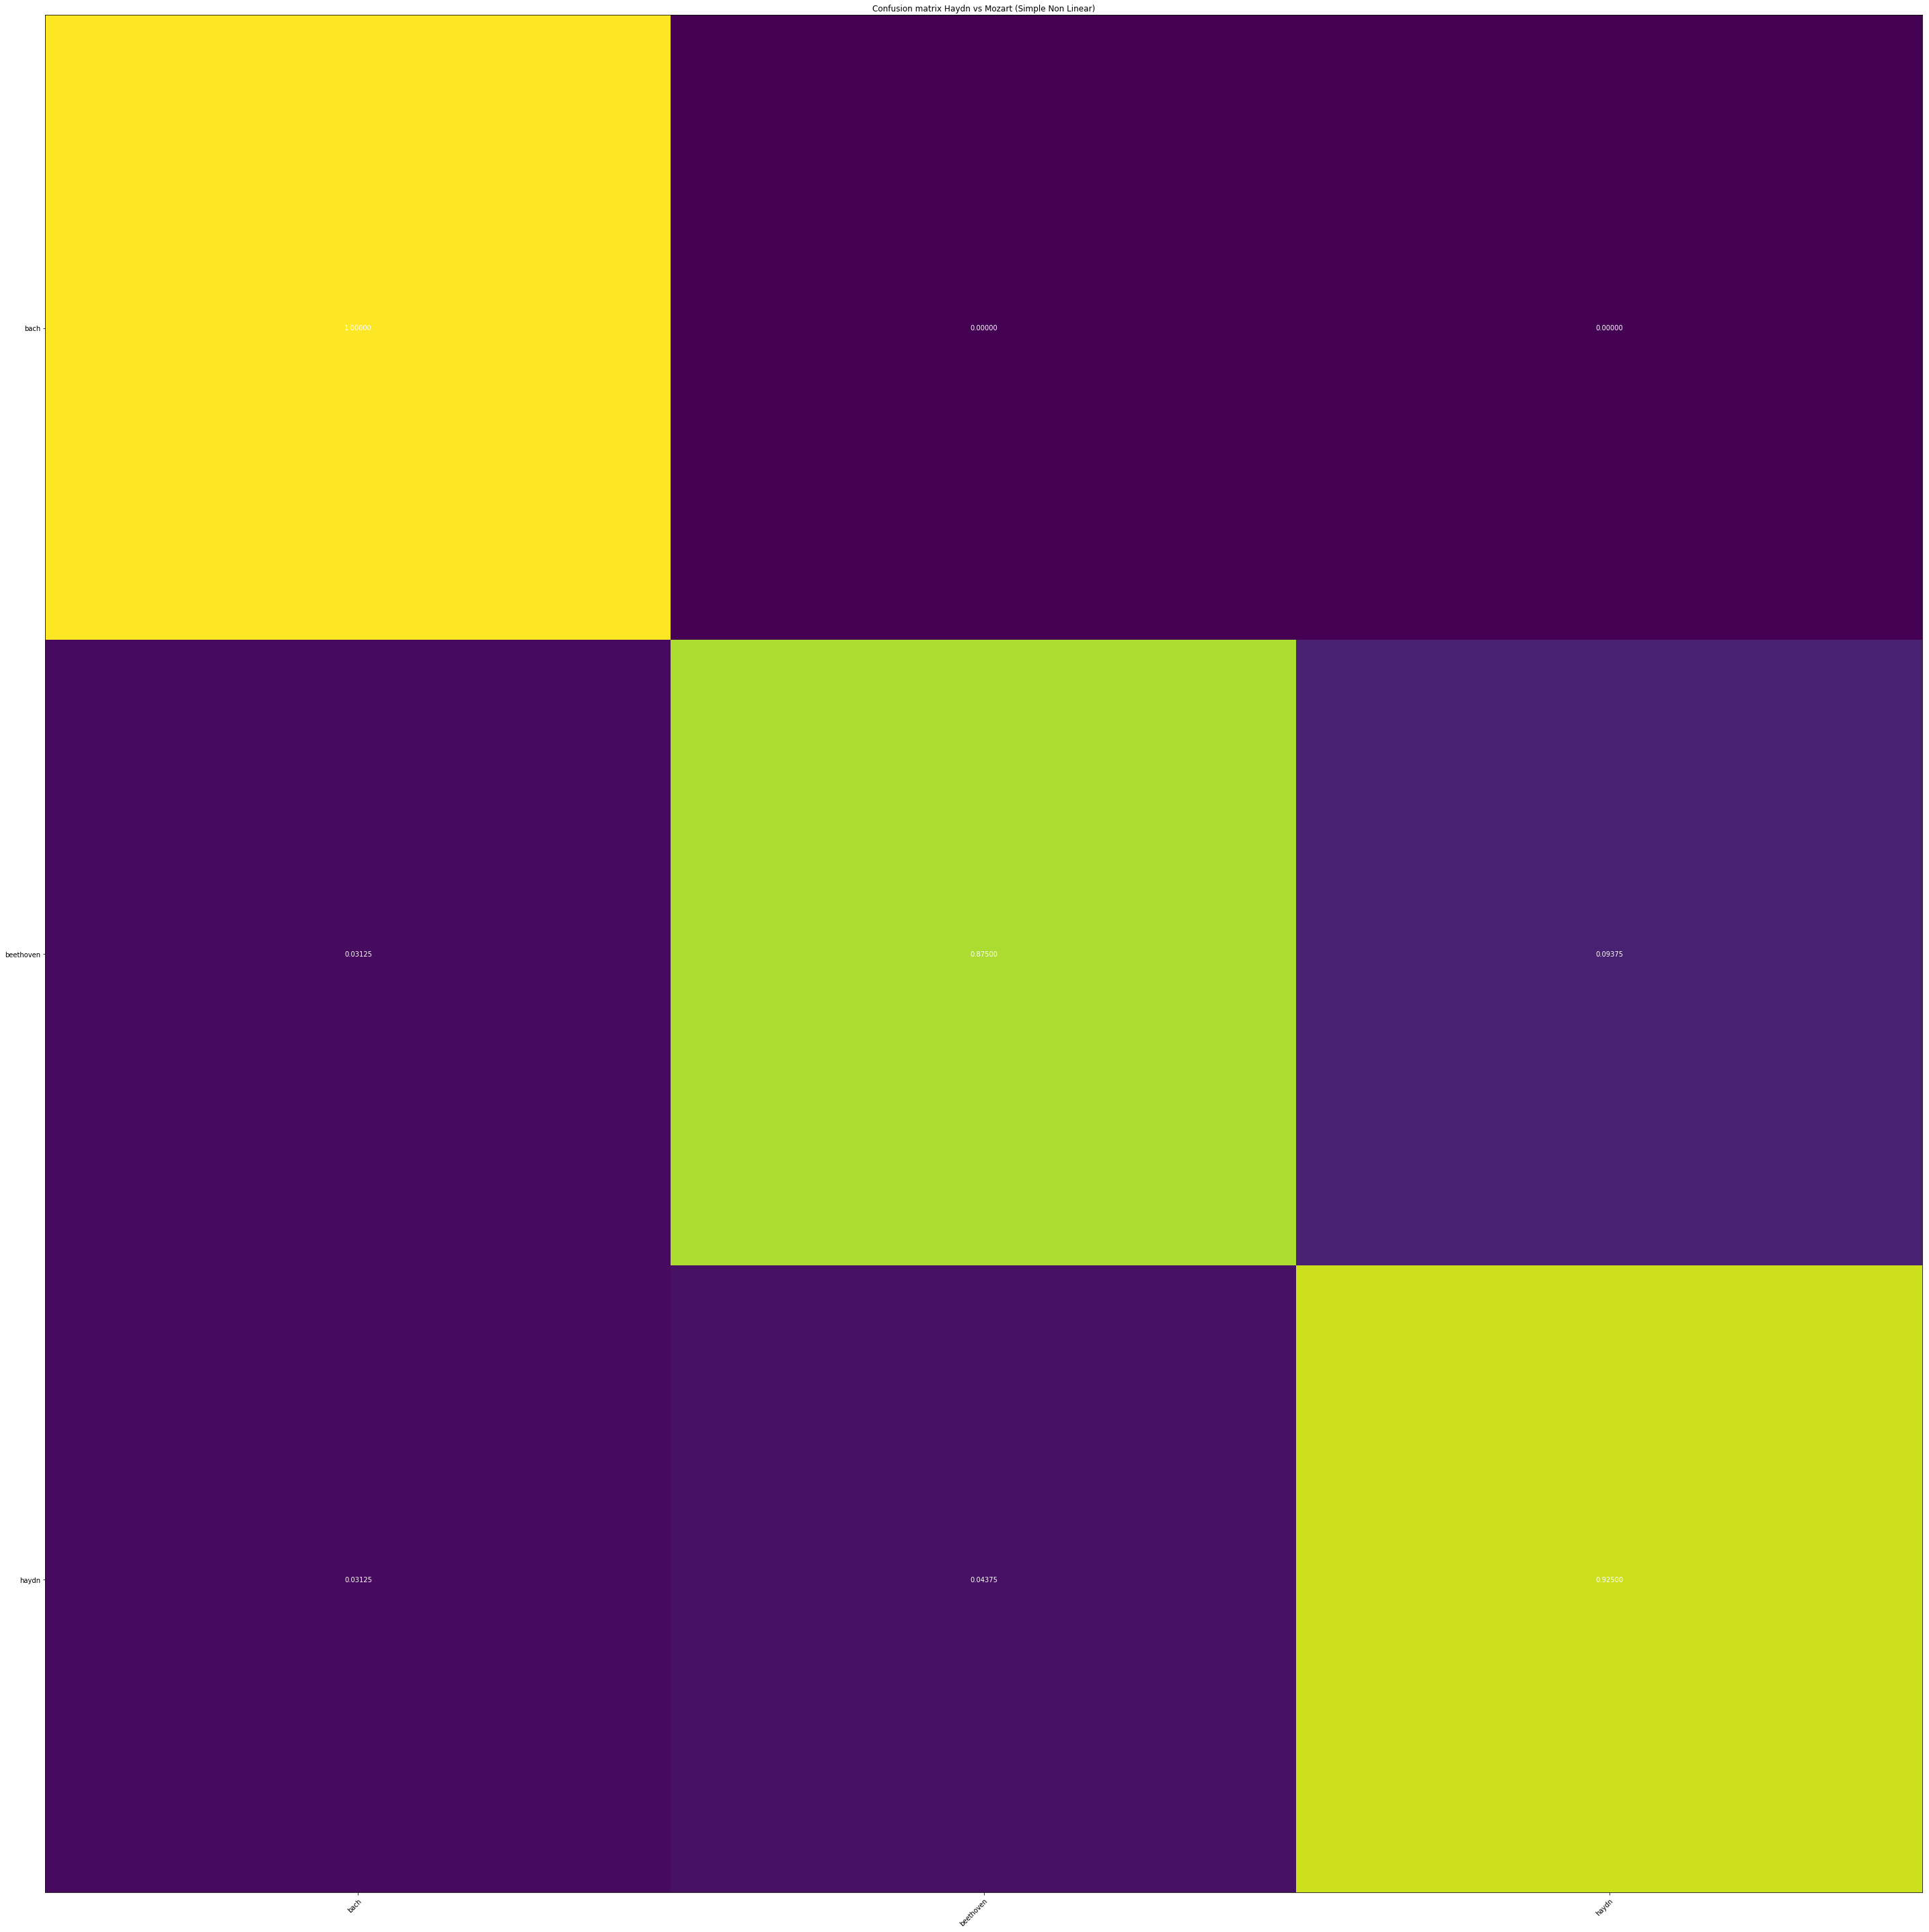

bach 46 / 46 = 1.0
beethoven 15 / 16 = 0.9375
haydn 18 / 20 = 0.9
79 82 0.9634146341463414
---------------------------------------------
---------------------------------------------
Fold 8
len validation_ids 400
len test_ids 246
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
wnotes torch.Size([64, 1, 1, 6, 39]) (14976)
wnotes2 torch.Size([512, 64, 1]) (32768)
wdur torch.Size([512, 330, 1]) (168960)
wtop torch.Size([512, 3]) (1536)
wnotesm torch.Size([256, 78, 1, 3]) (59904)
wdurationm torch.Size([256, 55, 1, 3]) (42240)
w2m torch.Size([256, 256, 1, 3]) (196608)
wtopm torch.Size([256, 3]) (768)
bias torch.Size([3]) (3)
Initialized graph with 517763 parameters
Initiating optimizer, 21 iterations/epoch.
acc_tr	acc_ts	iter	loss_tr	loss_ts	time	utime
57.00   49.06   0       2.67    3.31    3.13    2.50    
67.00   61.32   21      1.91    2.03    6.69    2.29    
78.50   67.92   4

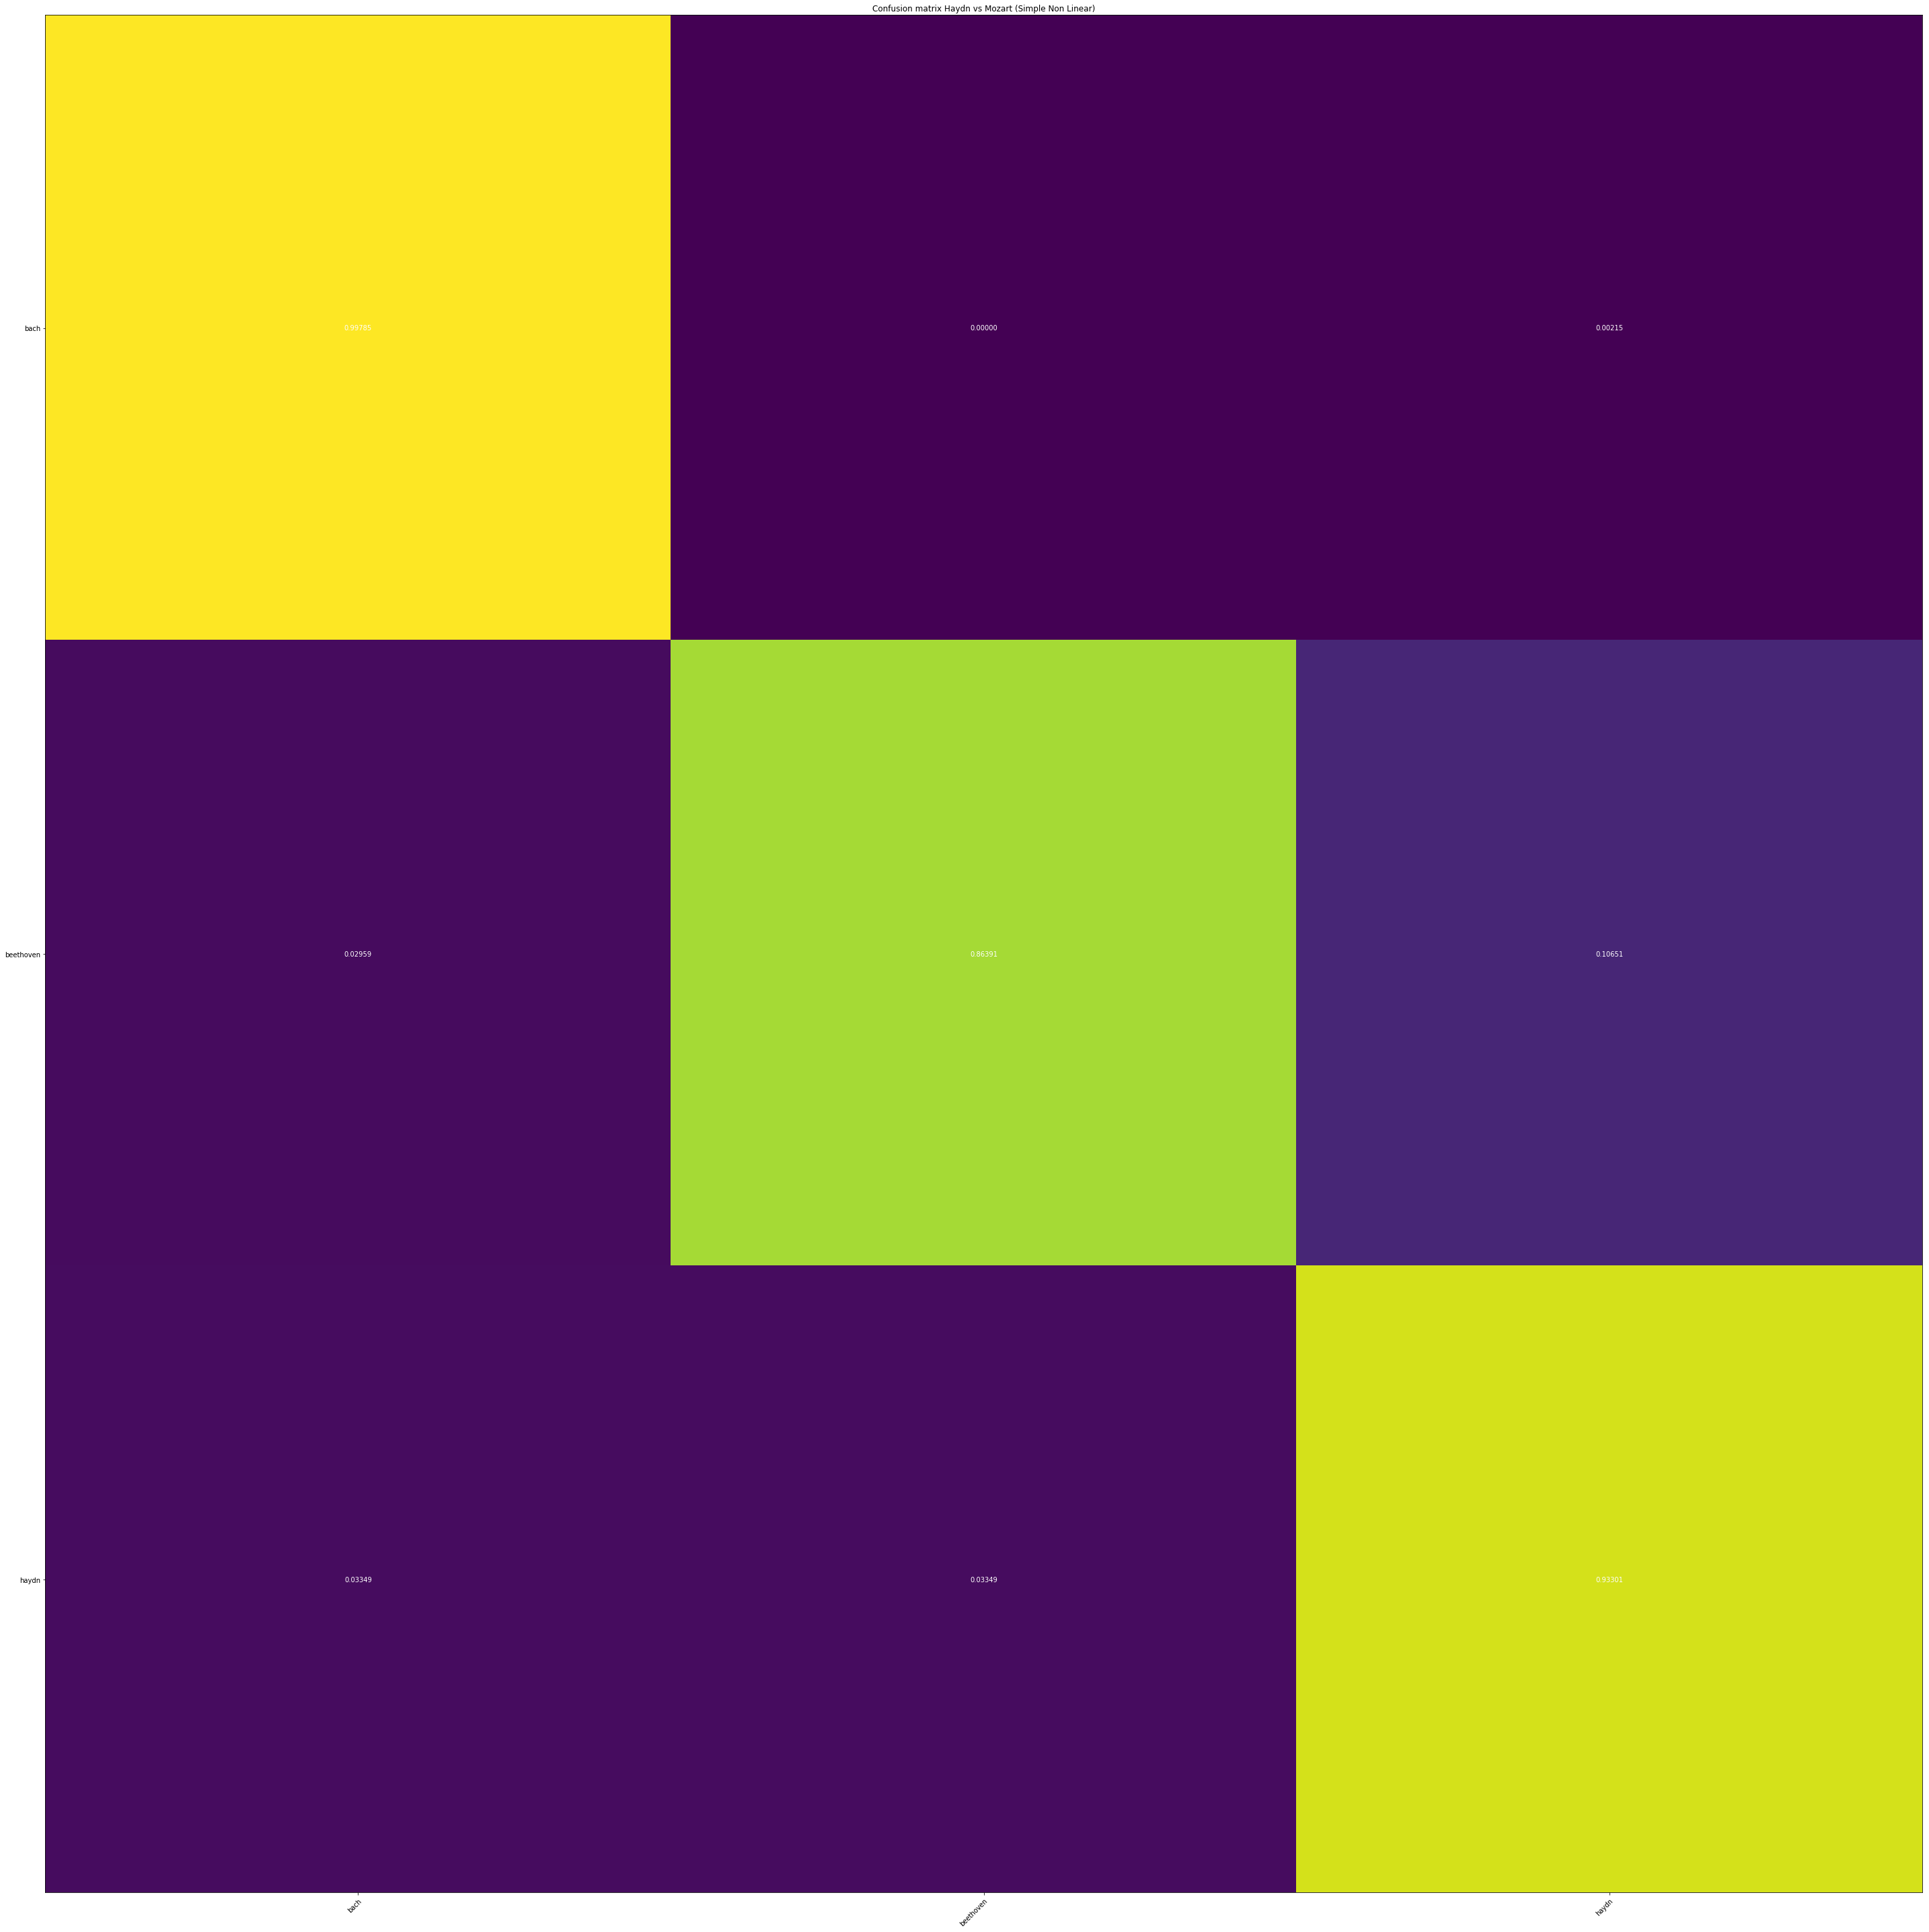

bach 51 / 52 = 0.9807692307692307
beethoven 19 / 25 = 0.76
haydn 27 / 29 = 0.9310344827586207
97 106 0.9150943396226415


In [4]:
validator = CrossValidator(Convnet, corpora, is_patches_model=True, patience=30, batch_size=32)
validator.run(context, checkpoint_dir=checkpoint_dir)